# Running Jupyter notebook in CSF3

## Commands to be run on CSF3

Run the following commands sequentially:
```
module load apps/binapps/jupyter-notebook/6.0.0
module load apps/gcc/R/3.6.0

## also run the following if you have connection problems
module load tools/env/proxy2

```

Run the Jupyter notebook server as a cluster job with the number of cores and memory appropriate to the analysis; examples are:


```
jupyter-notebook-csf	           # runs a serial (1-core) job - on a 4-6GB/core
jupyter-notebook-csf -p 2 -m 16	# runs a parallel 2-core job - on a 16GB RAM/core
                                   # Recommended for this example dataset
```



Your job 657643 ("jnotebook") has been submitted
Checking if job has already started…

Run `qstat` to make sure it is running on the cluster. Or type:
```
jupyter-notebook-csf -c 657643
```


You should see (as example): <br>
<div class="alert alert-info">
  <strong>Info!</strong> Please note the number 657643 is used as example and would be different in your case
</div>


## Running Jupyter notebook on desktop/laptop [ON YOUR LOCAL COMPUTER]:

Once the notebook job is running you can now set up the SSH tunnel on your local computer (not the CSF): 
<div class="alert alert-info">
  <strong>Info!</strong> You can get this instruction by typing the command shown on the screen or by typing 
</div>

```
cat jnotebook.o657643
```

Now to enable access from your local computer, run the following in your local machine \[as shown on 
```cat jnotebook.o657643```\] 

```
ssh -L 8888:hnode120:8888 [your-uni-id]@csf3.itservices.manchester.ac.uk
```

__DO NOT EXIT__ until you have finished your tunnelled session.

On your local browser (browser in your local computer NOT CSF) use the following URL:
```
http://localhost:8888
```

If you are asked for a token to login to the notebook, have a look in this _job's .e_ file for the token by running the following command:

```
jupyter-notebook-csf -t 657643
```

(you should only run the above command *after* the batch job has started)

After finishing,  you __must__ run the following command on the CSF3 to terminate the Jupyter batch job:

```
qdel 657643
```

<div class="alert alert-danger">
  <strong>Alert!</strong> Please do not put your machine into sleep mode before closing the tunneling window.
</div>

# 10-step analysis of scRNA-seq (10X Genomics)
## Bioinformatics Core Facility, University of Manchester

1. <a href=#section1>Preliminaries</a>
2. <a href=#section2>QC Analysis of cells and genes</a>
3. <a href=#section3>Quality filtering of cells</a>
4. <a href=#section4>Classification of cell cycle phase</a>
5. <a href=#section5>Filtering out low-abundance genes</a>
6. <a href=#section6>Normalization of read counts</a>
7. <a href=#section7>Identifying genes for feature selection (HVG)</a>
8. <a href=#section8>Analysis of the dataset using highly variable genes HVG</a>
9. <a href=#section9>Clustering cells</a>
10. <a href=#section10>Identifying marker genes for clusters</a>


# Project NEXTSEQ_#154 (Liver development)
This notebook documents the steps for the aggregated data with no normalisation by Cellranger

__Researcher:__ Louisa Nelson <br>
__PI:__ Stephen Taylor <br>
__Analyst:__ Syed Murtuza Baker <br>


## Project Description

Living biobanks are powerful resources, with the transformative aspect coming from the ability to perform detailed phenotypic studies on well-characterised models that accurately reflect a patient’s tumour, and in turn, the ability to correlate ex vivo observations with clinical chemotherapy responses. As such, living biobanks can potentially address limitations associated with established cancer cell lines, and indeed, our analysis shows that thus far, we have grossly underestimated the mitotic dysfunction in advanced human tumours.

These samples are basically an addition to  the one sample in the paper that was analysed previously. They are cells from patients with ovarian cancer, we isolated the tumour and stromal cells for each patient. And have mixed them back together to give 1 sample per patient.



### Aim of the project

The aims were

1. To cluster them establish the 2 populations
2. To establish the over-dispersed genes in the two populations

From the first sample `p53` and `XIST` were differentially expressed so you could use these to validate the initial clustering. The analysis after that would be the same as the previous sample


### Experimental Design:

- We analysed OCMs 38b, 59, 74–1 and 79 using a 10x Genomics platform. Tumour and stromal cells from the four pairs were mixed 3:1 and analysed in parallel. Ovarian cancer and stromal cells were cultured in OCMI media36 using a 50:50 mix of Nutrient Mixture Ham’s F12 (Sigma Aldrich) and Medium 199 (Life Technologies).
- So the only difference from the previous sample is that these have the tumour and stromals from the same patient mixed together in a `75%:25%` ratio



### Expected outcome

1. Compare samples interested in what is common as well as linking clusters to a previous experiment which was later publisehd [Nelson, L. et. al. A living biobank of ovarian cancer ex vivo models reveals profound mitotic heterogeneity. Nat Commun 11, 822 (2020)]( https://doi.org/10.1038/s41467-020-14551-2) 
2. How the expression of `XIST` and `TP53` are.


## Prior to the this analysis
## QC
http://bartzabel.ls.manchester.ac.uk/syed/2o332gW33C/web_summary.html


## Cellranger scripts

### Cellranger count

- Create jobscript with the following command

```
#!/bin/bash --login
#$ -cwd             # Job will run from the current directory
#$ -pe smp.pe 12    # Number of cores (can be 2--32)
cellranger count --id LN1_AS38 --fastqs /mnt/fls01-bcf01/ngsdata/Analysis/2019/nextseq/190709_NB500968_0129_AHVMT2BGXB_analysis/LouisaNelson/fastqs --sample LN1_AS38 --transcriptome /mnt/data-sets/bcf/softwareData/10xGenomics-CellRanger/3.0.0/refdata-cellranger-GRCh38-3.0.0 --jobmode=sge --mempercore=4
```
- Run it for each of the samples

### Cellranger aggr

Run the following command to aggregate all samples

```
#!/bin/bash --login
#$ -cwd             # Job will run from the current directory
#$ -pe smp.pe 12    # Number of cores (can be 2--32)
cellranger aggr --id=KY_aggr_noDepthNormalization --csv=aggr.csv --jobmode=sge --mempercore=5 --normalize=none     
```
You need to create the aggr.csv file first as

| library_id  |molecule_h5  |
|---|:---|
| LN1_AS38 |  /mnt/mr01-home01/mqbsxsm2/scratch/Louisa_Nelson_10XGenomics_scRNA-seq/LN1_AS38/outs/molecule_info.h5 |
| LN2_AS59_3  | /mnt/mr01-home01/mqbsxsm2/scratch/Louisa_Nelson_10XGenomics_scRNA-seq/LN2_AS59_3/outs/molecule_info.h5  |
| LN3_AS74  |  /mnt/mr01-home01/mqbsxsm2/scratch/Louisa_Nelson_10XGenomics_scRNA-seq/LN3_AS74/outs/molecule_info.h5 |
|  LN4_AS79 |  /mnt/mr01-home01/mqbsxsm2/scratch/Louisa_Nelson_10XGenomics_scRNA-seq/LN4_AS79/outs/molecule_info.h5 |




# 1. Preliminaries<a name='section1' />
- Load R libraries
- Set up color palettes. Default colorblind friendly color palette
- Load data (cellranger outputs) 
- Assign sample names 
- Make scater single cell analysis object
- Normalise

In [3]:
## Loading the libraries
## edits required to paths of R libraries
library(Seurat)
library(scater)
library(ggplot2)
library(scran)
library(GGally)
library(mclust)
library(Rtsne)
library(viridis)
library(umap)
library(tidyverse)
library(paletteer)
library(biomaRt)
library(org.Hs.eg.db)#human
# library("org.Mm.eg.db",lib.loc="/mnt/fls01-home01/mqbsslaz/R/x86_64-pc-linux-gnu-library/3.6/")#mouse
library (scater)
library(dynamicTreeCut)
library(ComplexHeatmap)
library(factoextra)
library(cluster)
library(edgeR)

In [4]:
writeLines(capture.output(sessionInfo()), "sessionInfo.txt")
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /opt/apps/apps/gcc/R/3.6.0/lib64/R/lib/libRblas.so
LAPACK: /opt/apps/apps/binapps/anaconda3/2019.07/lib/libmkl_rt.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] edgeR_3.26.5                limma_3.40.2               
 [3] cluster_2.1.0               factoextra_1.0.5           
 [5] ComplexHeatmap_2.0.0        dynamicTreeCut_1.63-1      
 [7] org.Hs.eg.db_3.8.2          Anno

In [5]:
load(".RData")

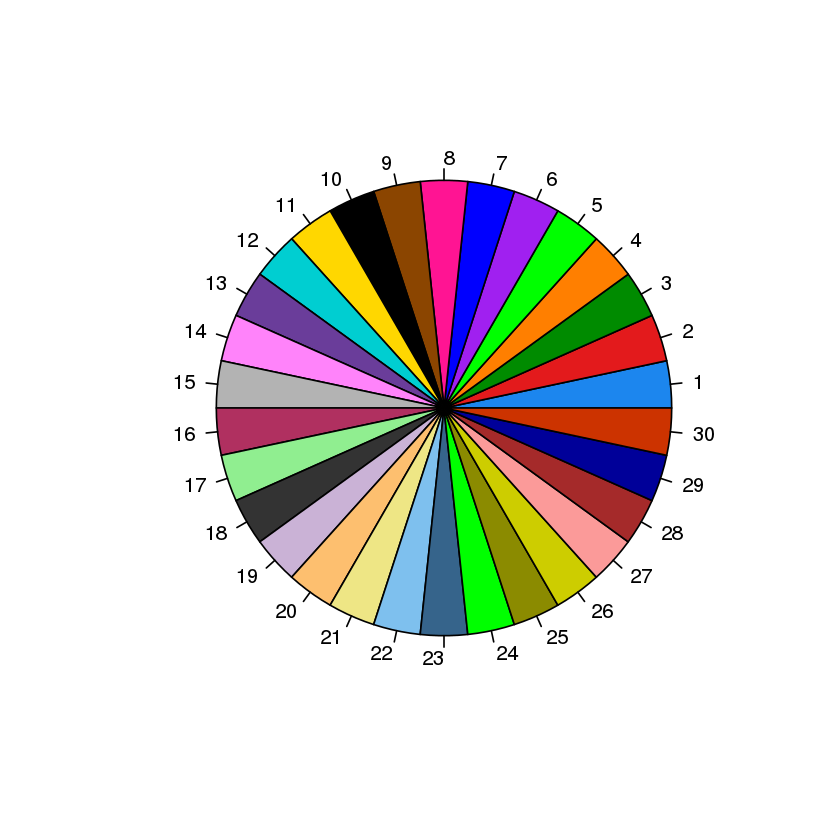

In [6]:
#cbPalette <- paletteer_d(package = "ggthemes", palette="calc", n=12)
 c30 <- c("dodgerblue2",#1
         "#E31A1C", #2 red
          "green4", #3
         "#FF7F00", #4 orange
           "green1",#5
         "purple",#6
         "blue1",#7
         "deeppink1",#8
         "darkorange4",#9
          "black",#10
         "gold1",#11
         "darkturquoise",#12
         "#6A3D9A", #13 purple
         "orchid1",#14
         "gray70",#15
          "maroon",#16
         "palegreen2",#17
          "#333333",#18
          "#CAB2D6", #19 lt purple
          "#FDBF6F", #20 lt orange
         "khaki2",#21
         "skyblue2",#22
         "steelblue4",#23
         "green1",#24
         "yellow4",#25
         "yellow3",#26
         "#FB9A99", #27 lt pink
         "brown",#28
         "#000099",#29
         "#CC3300"#30
         )
 
pie(rep(1,30), col=c30)

In [7]:
# Choosing colours for samples
c_sample_col <- c30[c(3,22,19,30)]
# Choosing colour for samples
c_clust_col <- c30[c(1,2,3,4,5,6,7,8,11,14,15,16,17,23,24)]

<font color=red>__edits required before next step__</font>

In [25]:
## Importing cellranger data for this dataset. EDITS REQUIRED
cellranger_pipestance_path <- "filtered_feature_bc_matrix_workshop/"
projectData <- Read10X(cellranger_pipestance_path)

In [27]:
#Checks: columns are cells
projectData[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
            CGAGTGCTCAGCTAGT-4 TTCTGTATCCACACAA-4 TTGAGTGGTTACGGAG-2
MIR1302-2HG                  .                  .                  .
FAM138A                      .                  .                  .
OR4F5                        .                  .                  .
AL627309.1                   .                  .                  .
AL627309.3                   .                  .                  .
            AACTTCTCAGAGGGTT-4 GTGATGTAGGCGTTGA-3
MIR1302-2HG                  .                  .
FAM138A                      .                  .
OR4F5                        .                  .
AL627309.1                   .                  .
AL627309.3                   .                  .

In [28]:
#Checks: size of data, genes and cell
dim(projectData)

[1] 33538  2000

In [30]:
## Sample information.  EDITS REQUIRED

## One sample
#Sample1_barcodes  <- data.frame(barcode=colnames(project_data), Sample="Eva_S1")

## Two (or more) samples
Sample1_barcodes  <- data.frame(barcode=colnames(projectData)[grep("1", colnames(projectData))], Sample="Patient1")
Sample2_barcodes  <- data.frame(barcode=colnames(projectData)[grep("2", colnames(projectData))], Sample="Patient2")
Sample3_barcodes  <- data.frame(barcode=colnames(projectData)[grep("3", colnames(projectData))], Sample="Patient3")
Sample4_barcodes  <- data.frame(barcode=colnames(projectData)[grep("4", colnames(projectData))], Sample="Patient4")

In [31]:
print(paste0('Number of Sample1 cells: ',dim(Sample1_barcodes)[1]))
print(paste0('Number of Sample2 cells: ',dim(Sample2_barcodes)[1]))
print(paste0('Number of Sample3 cells: ',dim(Sample3_barcodes)[1]))
print(paste0('Number of Sample4 cells: ',dim(Sample4_barcodes)[1]))


[1] "Number of Sample1 cells: 588"
[1] "Number of Sample2 cells: 369"
[1] "Number of Sample3 cells: 593"
[1] "Number of Sample4 cells: 450"


In [32]:
#Barcodes 
#For single sample
#annotBarcode <- Sample1_barcodes
#rownames(annotBarcode) <- annotBarcode$barcode
#head(annotBarcode)

## For multiple samples
annotBarcode <- rbind(Sample1_barcodes, Sample2_barcodes, Sample3_barcodes, Sample4_barcodes)
rownames(annotBarcode) <- annotBarcode$barcode
head(annotBarcode)

barcode            Sample  
TAGGTACTCGACGAGA-1 TAGGTACTCGACGAGA-1 Patient1
TGTGGCGCACCAGCTG-1 TGTGGCGCACCAGCTG-1 Patient1
CCCGAAGTCAAATGCC-1 CCCGAAGTCAAATGCC-1 Patient1
GACTCTCTCATCACCC-1 GACTCTCTCATCACCC-1 Patient1
ACGATGTTCAACTCTT-1 ACGATGTTCAACTCTT-1 Patient1
TCGCTTGGTCCGGACT-1 TCGCTTGGTCCGGACT-1 Patient1

__Analysis note__ Creating the `SingleCellExperiment` object using `scater`. 

In [33]:
#make scater object
cdSc <- SingleCellExperiment(assays = list(counts = as.matrix(projectData)))#this object from library scater
#as.matrix allows it to load because problems sparse matrix and dense matrix. Actually starts sparse, then dense, then sparse!
colData(cdSc)$barcode <- annotBarcode$barcode #colData for cells
colData(cdSc)$Sample <- annotBarcode$Sample
rowData(cdSc)$symbol <- rownames(projectData) #rowData for genes
cdSc <- scater::calculateQCMetrics(cdSc)
cdSc

class: SingleCellExperiment 
dim: 33538 2000 
metadata(0):
assays(1): counts
rownames(33538): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(8): symbol is_feature_control ... total_counts
  log10_total_counts
colnames(2000): CGAGTGCTCAGCTAGT-4 TTCTGTATCCACACAA-4 ...
  TTGCATTTCACCGGGT-1 TGGGCTGGTCAACCTA-3
colData names(11): barcode Sample ... pct_counts_in_top_200_features
  pct_counts_in_top_500_features
reducedDimNames(0):
spikeNames(0):

#### Viewing information related with cells
We will use `colData()` function to access the metadata related with cells

In [19]:
#Checks: should be about 12
names(colData(cdSc))

[1] "barcode"                        "Sample"                        
 [3] "is_cell_control"                "total_features_by_counts"      
 [5] "log10_total_features_by_counts" "total_counts"                  
 [7] "log10_total_counts"             "pct_counts_in_top_50_features" 
 [9] "pct_counts_in_top_100_features" "pct_counts_in_top_200_features"
[11] "pct_counts_in_top_500_features"

#### Viewing QC information related with genes
We use `rowData()` function to access the metadata related with genes

In [20]:
#Checks: dropouts are statistical negatives, could be true negatives or false negatives (not detected properly)
names(rowData(cdSc))

[1] "symbol"                "is_feature_control"    "mean_counts"          
[4] "log10_mean_counts"     "n_cells_by_counts"     "pct_dropout_by_counts"
[7] "total_counts"          "log10_total_counts"

In [34]:
#this normalises prior to our own filtering. So gets redone, but sometimes requested.
exprs(cdSc) <- log2(scater::calculateCPM(cdSc, use_size_factors = TRUE) + 1)

__Normalisation notes__ Syed note about an older version of scater which automatically normalised the counts in its "log10counts". Not doing that at the moment.
Here we use log2-counts-per-million with an offset of 1 as the exprs values. We have to note that the CPM for scater is different than the regular CPM calculation as we are considering the step-size here. 

The value of the log-CPMs is explained by adding a prior count to avoid undefined values after the log-transformation, multiplying by a million, and dividing by the mean library size. This size factors are used to define the effective library sizes. This is done by scaling all size factors such that the mean scaled size factor is equal to the mean sum of counts across all features. The effective library sizes are then used to in the denominator of the CPM calculation. The way that `scater` calculates the log-normalized counts are

```
lib.sizes <- colSums(counts(example_sceset))
lib.sizes <- lib.sizes/mean(lib.sizes)
log2(counts(example_sceset)[1,]/lib.sizes+1)
```


# 2. QC Analysis of cells and genes<a name='section2' />
Below are different plots to visualize the summary statistics.

### Cell QC
Low-quality cells need to be identified and removed to ensure that the technical effects do not distort downstream analysis results. Three common measures of cell quality are:
- the total counts or __library size__ per cell
- the __number of expressed genes__ in each cell library
- proportion of __mitochondrial genes__ in each cell library

The __library size__ is defined as the total sum of counts across all genes. Cells with relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured (i.e., converted into cDNA and amplified) during library preparation. 

The __number of expressed genes__ in each cell is defined as the number of genes with non-zero counts for that cell. Any cell with very few expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully captured. 

High proportions of reads mapping to __mitochondrial genes__ are indicative of poor-quality cells ([Ilicic et al., 2016](https://f1000research.com/articles/5-2122/v2#ref-14); [Islam et al., 2014](https://f1000research.com/articles/5-2122/v2#ref-16)), possibly because of increased apoptosis and/or loss of cytoplasmic RNA from lysed cells. 



### Viewing information related with cells
`colData(cdSc)`

### Viewing QC information related with genes
`rowData(cdSc)`

### Mitochondrial Analysis 
<font color=red>__edits required human or mouse__</font>

In [46]:
# Human
my.ids <- gsub('\\..*','',tolower(rownames(cdSc)))
ensembl = useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", mirror = "useast")
#ensembl = useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", host = "useast.ensembl.org")
chrName <- getBM(attributes=c('ensembl_gene_id','hgnc_symbol','chromosome_name'), filters = 'hgnc_symbol', values =my.ids, mart = ensembl)

is.mito <- chrName$chromosome_name == "MT" & !is.na(chrName$chromosome_name)
sum(is.mito)

## Mouse
#is.mito <- grepl("^mt-", rowData(cdSc)$symbol)
#cdSc <- calculateQCMetrics(cdSc, feature_controls=list(Mt=is.mito))
#print(paste0('Number of annotated mitochondrial genes = ',as.character(sum(is.mito))))


[1] 13

In [47]:
cdSc <- calculateQCMetrics(cdSc, feature_controls=list(Mt=is.mito))
names(colData(cdSc))

[1] "barcode"                                       
 [2] "Sample"                                        
 [3] "is_cell_control"                               
 [4] "total_features_by_counts"                      
 [5] "log10_total_features_by_counts"                
 [6] "total_counts"                                  
 [7] "log10_total_counts"                            
 [8] "pct_counts_in_top_50_features"                 
 [9] "pct_counts_in_top_100_features"                
[10] "pct_counts_in_top_200_features"                
[11] "pct_counts_in_top_500_features"                
[12] "total_features_by_counts_endogenous"           
[13] "log10_total_features_by_counts_endogenous"     
[14] "total_counts_endogenous"                       
[15] "log10_total_counts_endogenous"                 
[16] "pct_counts_endogenous"                         
[17] "pct_counts_in_top_50_features_endogenous"      
[18] "pct_counts_in_top_100_features_endogenous"     
[19] "pct_counts_in_top_200_features_endogenous"     
[20] "pct_counts_in_top_500_features_endogenous"     
[21] "total_features_by_counts_feature_control"      
[22] "log10_total_features_by_counts_feature_control"
[23] "total_counts_feature_control"                  
[24] "log10_total_counts_feature_control"            
[25] "pct_counts_feature_control"                    
[26] "pct_counts_in_top_50_features_feature_control" 
[27] "pct_counts_in_top_100_features_feature_control"
[28] "pct_counts_in_top_200_features_feature_control"
[29] "pct_counts_in_top_500_features_feature_control"
[30] "total_features_by_counts_Mt"                   
[31] "log10_total_features_by_counts_Mt"             
[32] "total_counts_Mt"                               
[33] "log10_total_counts_Mt"                         
[34] "pct_counts_Mt"                                 
[35] "pct_counts_in_top_50_features_Mt"              
[36] "pct_counts_in_top_100_features_Mt"             
[37] "pct_counts_in_top_200_features_Mt"             
[38] "pct_counts_in_top_500_features_Mt"

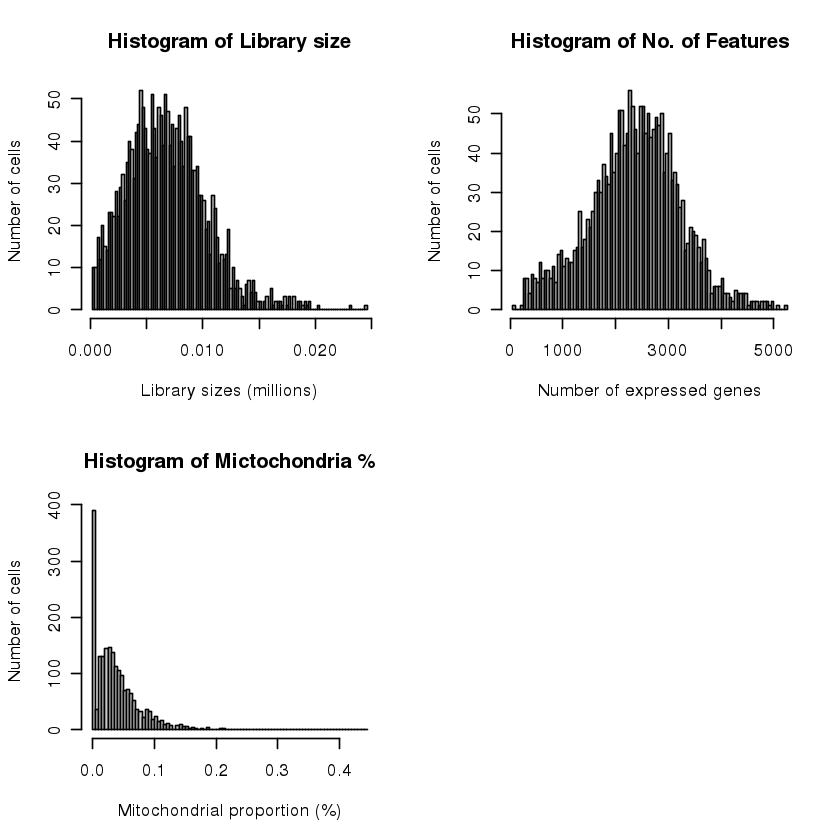

In [48]:
## Plotting the histograms of QC entries.
par(mfrow=c(2,2))
hist((cdSc$total_counts)/1e6, xlab="Library sizes (millions)", main="Histogram of Library size",
     breaks=100, col="grey80", ylab="Number of cells")

hist(cdSc$total_features_by_counts, xlab="Number of expressed genes", main="Histogram of No. of Features",
     breaks=100, col="grey80", ylab="Number of cells")

hist(cdSc$pct_counts_Mt, xlab="Mitochondrial proportion (%)",
     ylab="Number of cells", breaks=100, main="Histogram of Mictochondria %", col="grey80")

In [49]:
summary(cdSc$pct_counts_Mt)#keep an eye on Max, i.e. cells with high mito

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01286 0.03079 0.03909 0.05497 0.44395 

__MITOCHONDRIAL GENES QC NOTES__
- A mean below 10% is very good.
- A mean above 25% is no good.

__MITOCHONDRIAL GENES QC NOTES FOR THIS DATASET__ <font color=red>__edits required__</font>
- The summary statistics for mitochondrial read proportion is reasonably good. 
- However, there are some outlier cells expressing very high mitocondrial genes. These will be filtered out.

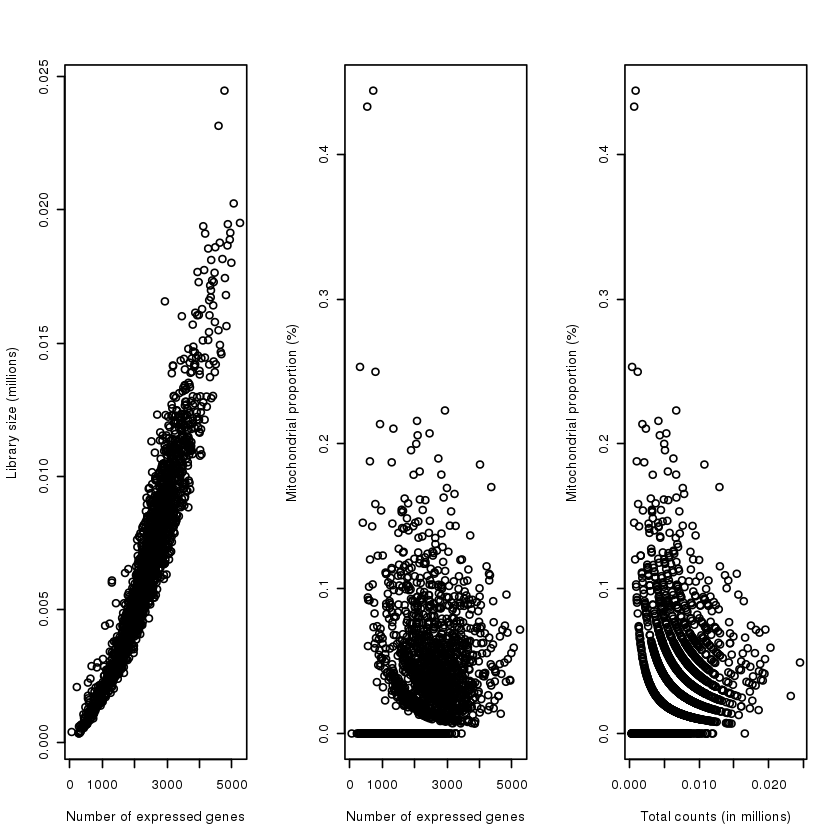

In [51]:
par(mfrow=c(1,3))
plot(cdSc$total_features_by_counts, cdSc$total_counts/1e6, xlab="Number of expressed genes",
    ylab="Library size (millions)")
plot(cdSc$total_features_by_counts, cdSc$pct_counts_Mt, xlab="Number of expressed genes",
    ylab="Mitochondrial proportion (%)")
plot(cdSc$total_counts/1e6, cdSc$pct_counts_Mt, xlab="Total counts (in millions)",
    ylab="Mitochondrial proportion (%)")

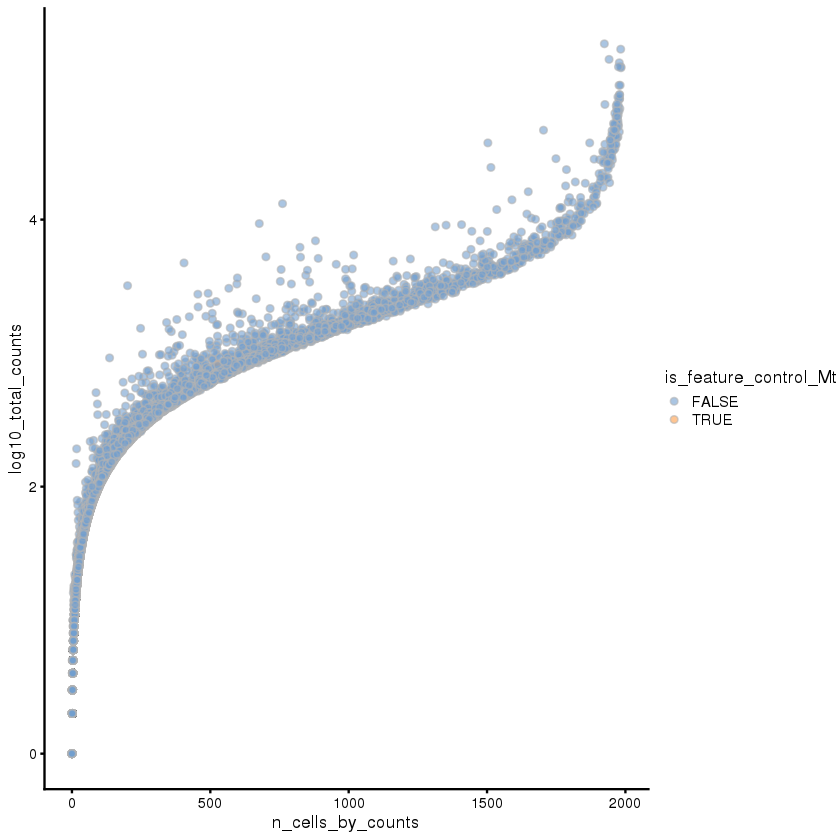

In [50]:
## How the counts are distributed across the genes
plotRowData(cdSc, x = "n_cells_by_counts", y = "log10_total_counts", colour_by = "is_feature_control_Mt")

__This plot__ shows log10 total counts per gene (y-axis) versus number of cells expressing that gene (x-axis). Generally, in single cell datasets there are some genes with very low, or very high, total counts, which accounts for the S shape of the plot.

Mitochondrial genes (marked in orange) often appear at the top right corner of the figure since they are highly expressed in most cells. It is only a problem if these genes make up the majority of a cell's reads (more than 80%). These problematic cells are removed further down this workflow.

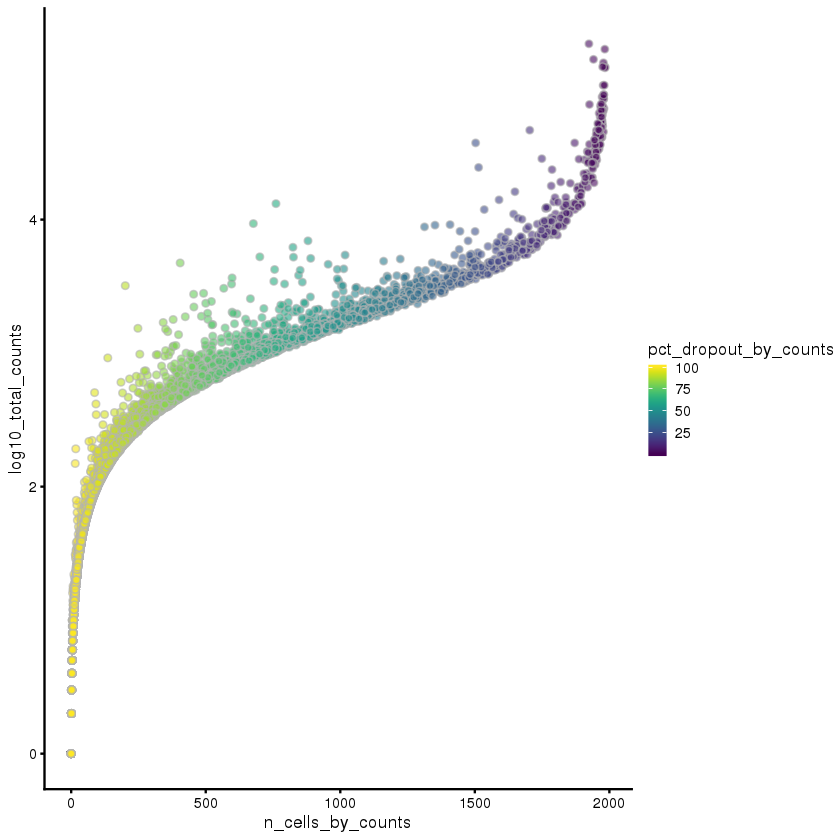

In [52]:
plotRowData(cdSc, x = "n_cells_by_counts", y = "log10_total_counts", colour_by = "pct_dropout_by_counts")

__Dropouts__ is a term for genes with no read counts.
As expected, cells with low number of reads have higher percentage of gene dropouts.

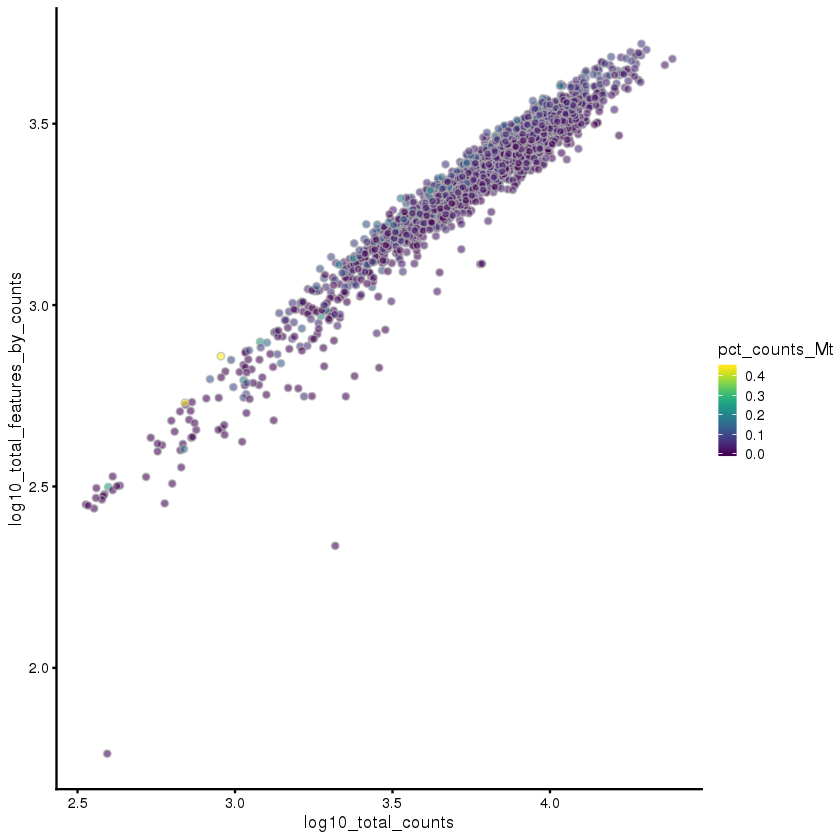

In [53]:
## How the counts are distributed across the cells
plotColData(cdSc, x = "log10_total_counts", y = "log10_total_features_by_counts", col = "pct_counts_Mt")

Cells on the linear pattern show a good correlation between total counts and the number of gene features with counts. Problematic cells deviate from the linear trend.

Cells with a very high proportion of mitchondrial reads are problematic (e.g. in apoptosis) ([Ilicic et al., 2016](https://f1000research.com/articles/5-2122/v2#ref-14); [Islam et al., 2014](https://f1000research.com/articles/5-2122/v2#ref-16)). They will be removed by the QC filtering. 

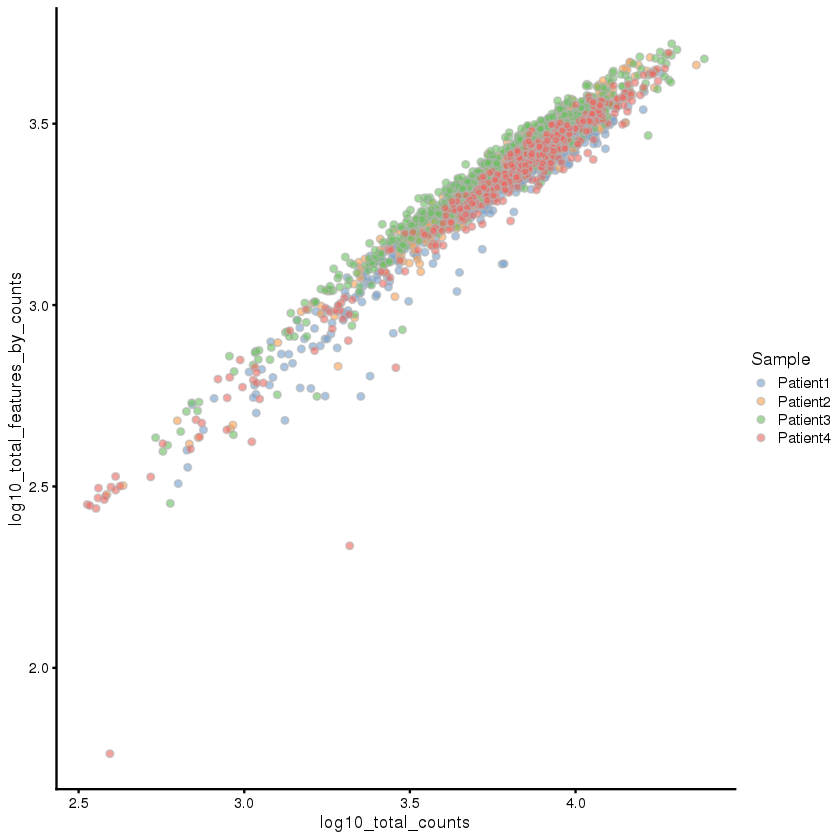

In [54]:
plotColData(cdSc, x = "log10_total_counts", y = "log10_total_features_by_counts", col = "Sample")

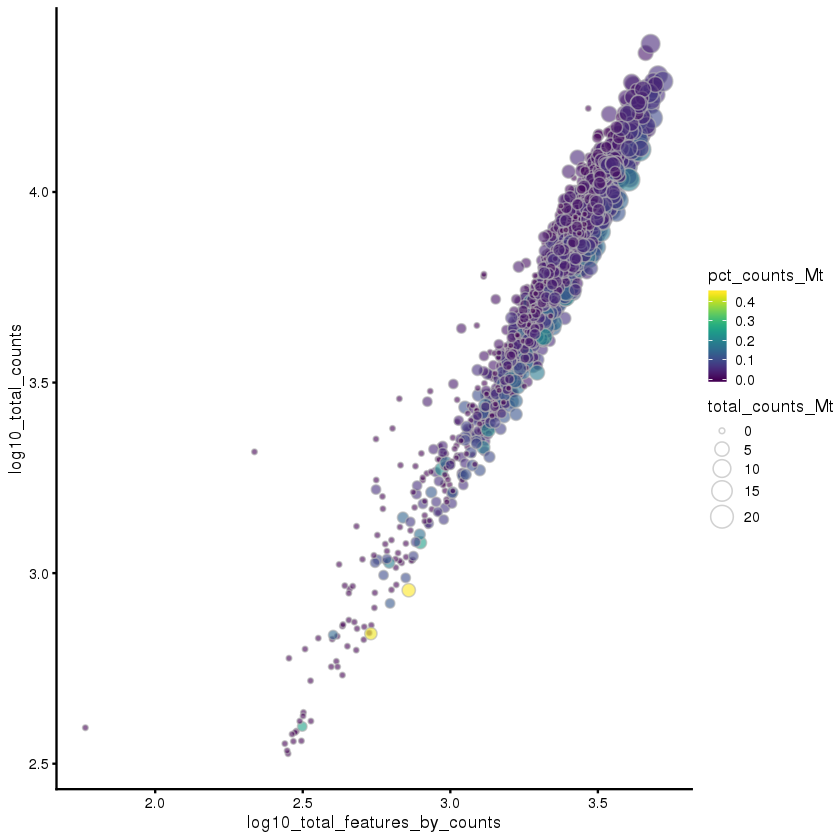

In [55]:
plotColData(cdSc, x = "log10_total_features_by_counts", y="log10_total_counts", size_by ="total_counts_Mt", colour_by  = "pct_counts_Mt")

# 3. Quality filtering of cells<a name='section3' />
__Picking thresholds for filtering out poor cells__ is not straightforward for different metrics as their absolute values depend on the protocol and biological system. For example, sequencing to greater depth will lead to more reads, regardless of the quality of the cells. To obtain an adaptive threshold, the assumption made here is that most of the dataset consists of high-quality cells. Plots to facilitate picking thresholds for cell cutoffs are below.

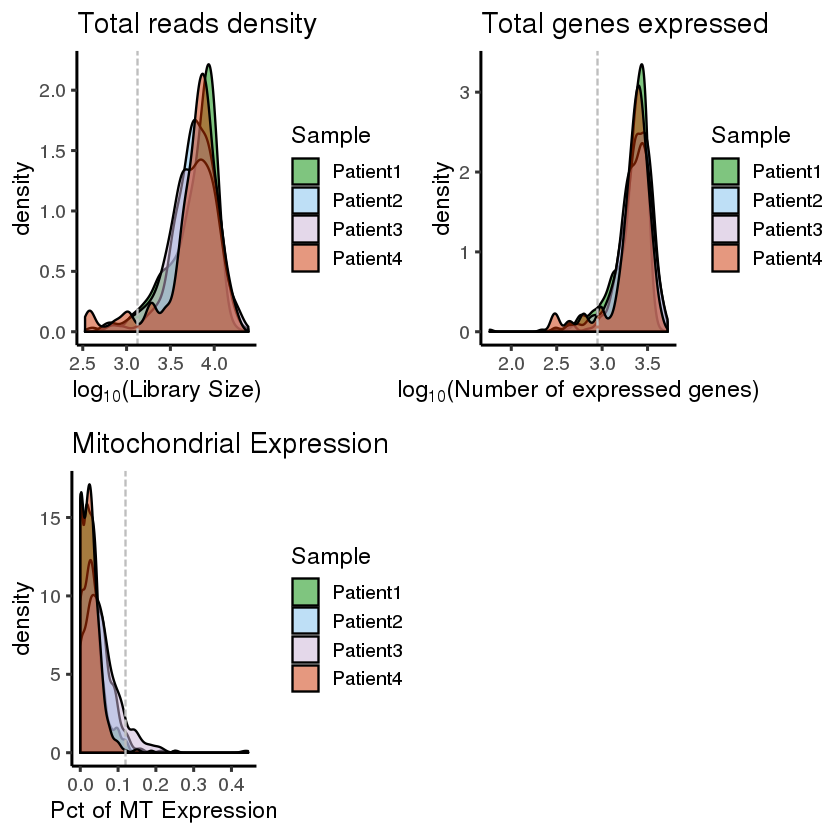

In [56]:
cut_off_reads <- median(cdSc$log10_total_counts) - 3*mad(cdSc$log10_total_counts)
df <- data.frame(x=cdSc$log10_total_counts, Sample = cdSc$Sample)
plot_reads <- ggplot(df,
       aes(x = x, fill = as.factor(Sample))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_reads, colour="grey", linetype = "longdash") +
       labs(x = expression('log'[10]*'(Library Size)'), title = "Total reads density", fill = "Sample") + 
       theme_classic(base_size = 14)+
       scale_fill_manual(values=c_sample_col)


cut_off_mRNA <- median(cdSc$log10_total_features_by_counts) - 3*mad(cdSc$log10_total_features_by_counts)
df <- data.frame(x=cdSc$log10_total_features_by_counts, Sample = cdSc$Sample)
plot_mRNA <- ggplot(df,
       aes(x = x, fill = as.factor(Sample))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_mRNA, colour="grey", linetype = "longdash") +
       labs(x = expression('log'[10]*'(Number of expressed genes)'), title = "Total genes expressed", fill = "Sample") + 
       theme_classic(base_size = 14)+
       scale_fill_manual(values=c_sample_col)


cut_off_MT <- median(cdSc$pct_counts_Mt) + 3*mad(cdSc$pct_counts_Mt)
df <- data.frame(x=cdSc$pct_counts_Mt, Sample = cdSc$Sample)
plot_MT <- ggplot(df,
       aes(x = x, fill = as.factor(Sample))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_MT, colour="grey", linetype = "longdash") +
       labs(x = expression('Pct of MT Expression'), title = "Mitochondrial Expression", fill = "Sample") + 
       theme_classic(base_size = 14)+
       scale_fill_manual(values=c_sample_col)

multiplot(plot_reads, plot_MT, plot_mRNA,  cols=2)

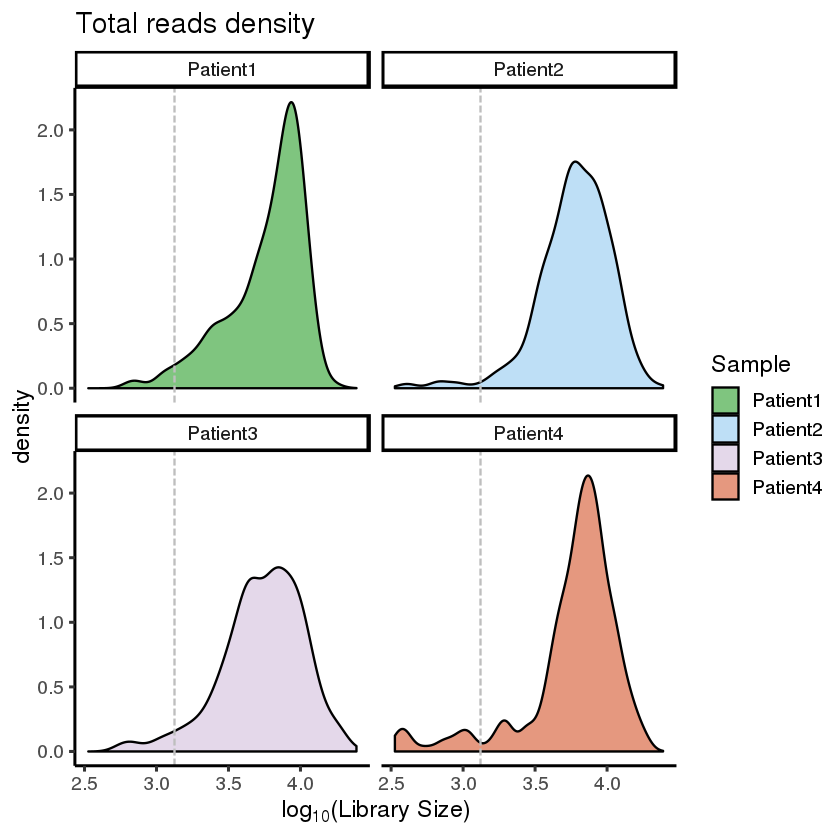

In [67]:
df <- data.frame(x=cdSc$log10_total_counts)
as_tibble(df) %>%
  dplyr::mutate("Sample" = cdSc$Sample) %>%
  ggplot( aes(x = x, fill = as.factor(Sample))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_reads, colour="grey", linetype = "longdash") +
       labs(x = expression('log'[10]*'(Library Size)'), title = "Total reads density", fill = "Sample") + 
       theme_classic(base_size = 14)+
       scale_fill_manual(values=c_sample_col) + facet_wrap(~Sample, nrow=2,ncol=2)

__The distribution of the reads, number of expressed genes and the percent of MT expression.__

The dotted line represents the threshold which is the 3 Median Absolute Deviation (MAD). For the top two figures, cells on the left of this threshold would be filtered out and for the bottom figure, cells on the right of this figure would be filtered out.

Cells are removed with log-library sizes that are more than 3 median absolute deviations (MADs) below the median log-library size. (A log-transformation improves resolution at small values, especially when the MAD of the raw values is comparable to or greater than the median). 

Similarly cells are removed where the log-transformed number of expressed genes is 3 MADs below the median. 

Finally, cells are removed having pct of MT expression below 3 MAD.




In [57]:
dim(cdSc)

[1] 33538  2000

In [58]:
print(paste0('Cells removed if: '))
print(paste0('Read count below Libsize Cutoff: ',10^cut_off_reads))
print(paste0('Number of genes expressed below Feature Cutoff: ',10^cut_off_mRNA))
print(paste0('MT percent above Mito Cutoff: ',cut_off_MT))

[1] "Cells removed if: "
[1] "Read count below Libsize Cutoff: 1325.66714005457"
[1] "Number of genes expressed below Feature Cutoff: 884.168125530497"
[1] "MT percent above Mito Cutoff: 0.120234511745261"


In [59]:
libsize.drop <- isOutlier(cdSc$total_counts, nmads=3, type="lower", log=TRUE)
feature.drop <- isOutlier(cdSc$total_features_by_counts, nmads=3, type="lower", log=TRUE)
mito.drop <- isOutlier(cdSc$pct_counts_Mt, nmads=3, type="higher")
print(paste0('Number of cells removed:'))
data.frame(ByLibSize=sum(libsize.drop), ByFeature=sum(feature.drop), 
           ByMito=sum(mito.drop))

[1] "Number of cells removed:"


ByLibSize ByFeature ByMito
1 76        110       71

In [60]:
#Generate, the `scater` object with this filtered profile.
cdScFilt <- cdSc[,!(libsize.drop | feature.drop | mito.drop)]
cdScFilt <- calculateQCMetrics(cdScFilt)
print(paste0("Total cells before quality filtering = ",dim(cdSc)[2]))
print(paste0('Total cells before quality filtering, per sample:'))
table(colData(cdSc)$Sample)
print(paste0("Total cells remaining after quality filtering = ",dim(cdScFilt)[2]))
print(paste0('Total cells after quality filtering, per sample:'))
table(colData(cdScFilt)$Sample)

[1] "Total cells before quality filtering = 2000"
[1] "Total cells before quality filtering, per sample:"



Patient1 Patient2 Patient3 Patient4 
     588      369      593      450 

[1] "Total cells remaining after quality filtering = 1828"
[1] "Total cells after quality filtering, per sample:"



Patient1 Patient2 Patient3 Patient4 
     548      352      516      412 

__QC plots below__ to check result and decide whether further filtering is required.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


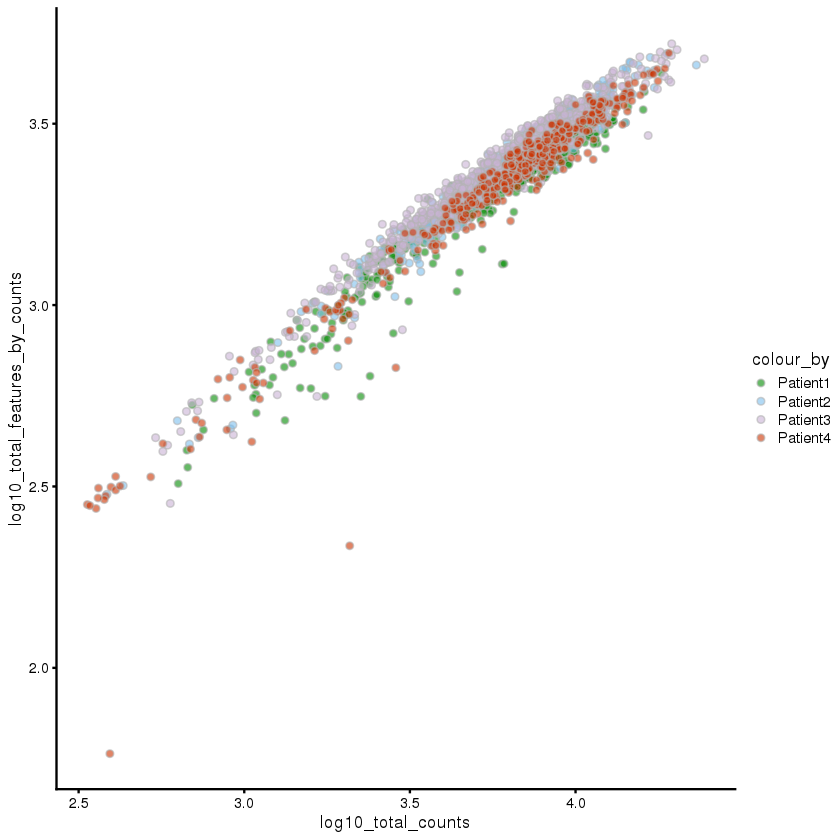

In [61]:
## Before filtering cells
plotColData(cdSc, x="log10_total_counts",y="log10_total_features_by_counts", colour_by = "Sample") +
       scale_fill_manual(values=c_sample_col)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


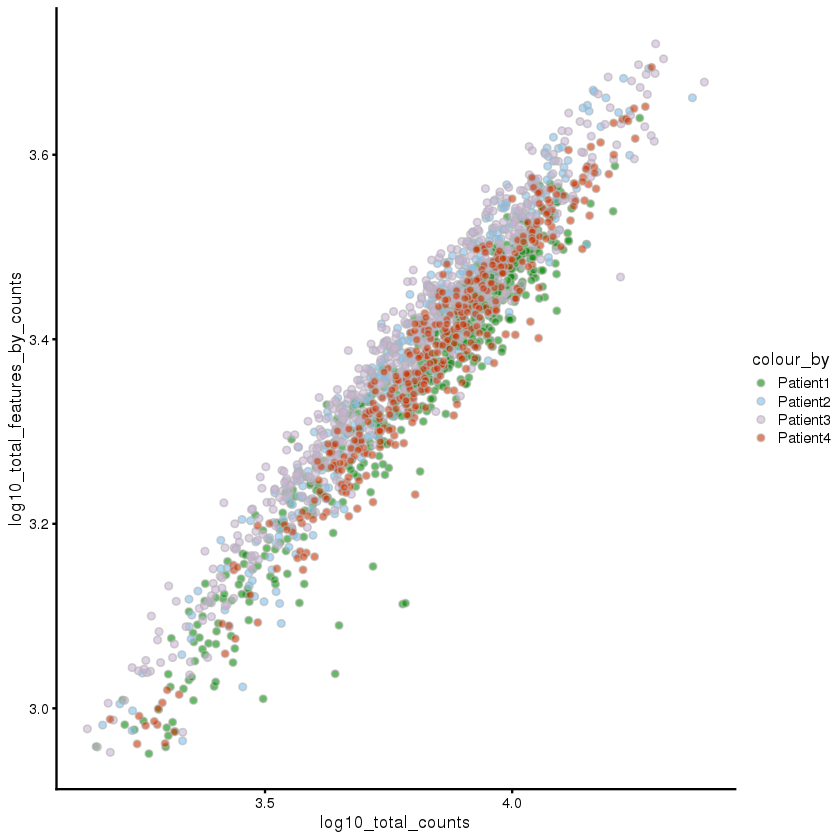

In [62]:
# After filtering cells
plotColData(cdScFilt, x="log10_total_counts",y="log10_total_features_by_counts", colour_by = "Sample") +
       scale_fill_manual(values=c_sample_col)

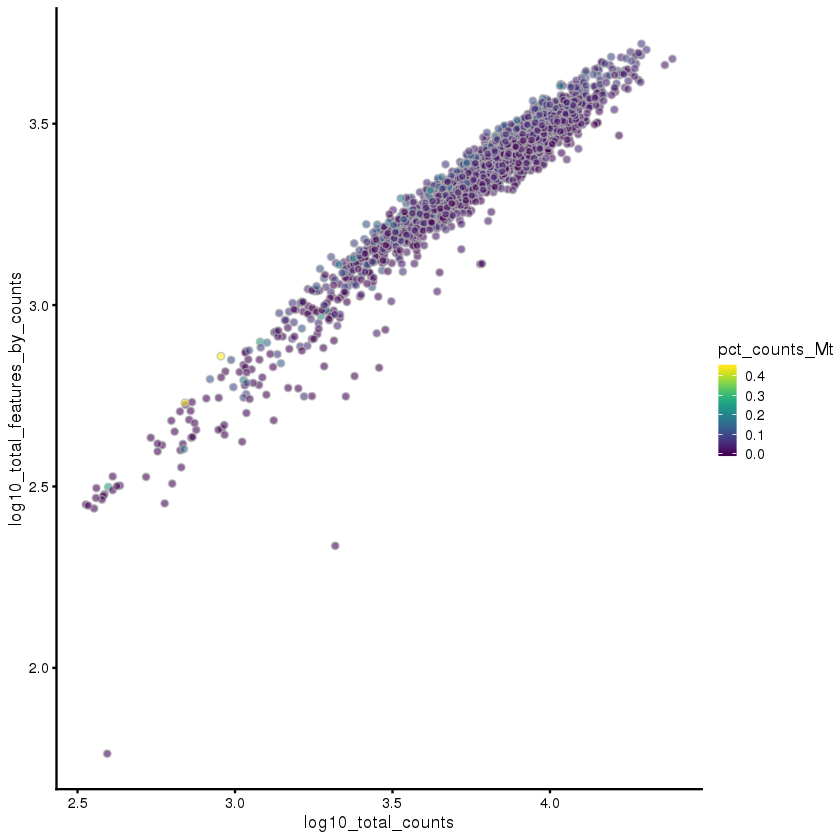

In [63]:
#before filtering cells
plotColData(cdSc, x = "log10_total_counts", y = "log10_total_features_by_counts", colour_by = "pct_counts_Mt")

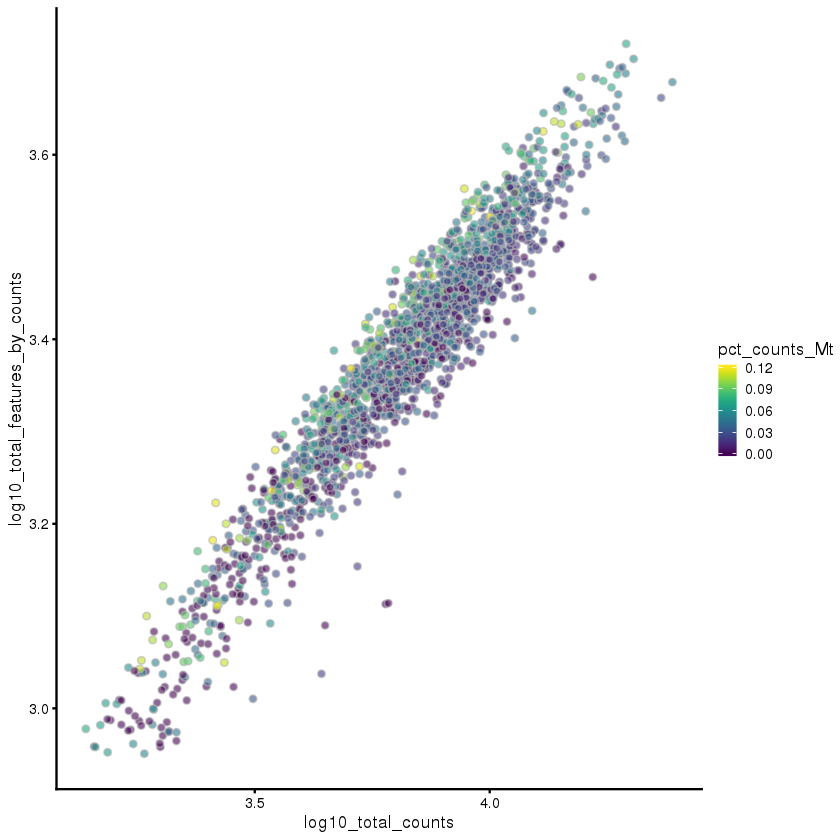

In [64]:
#after filtering cells
plotColData(cdScFilt, x = "log10_total_counts", y = "log10_total_features_by_counts", colour_by = "pct_counts_Mt")

__Violin plots below__ to investigate possible outlier cells with high read-depth (could be doublets). 

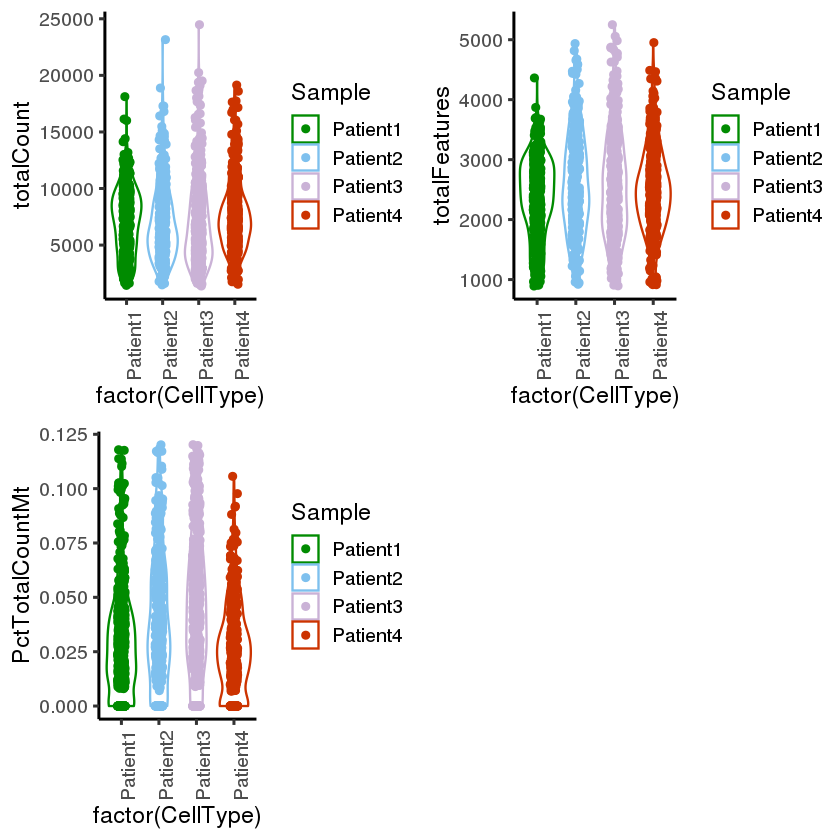

In [65]:
df <- data.frame(Cell=colnames(cdScFilt), CellType=cdScFilt$Sample, totalFeatures=cdScFilt$total_features_by_counts, totalCount=cdScFilt$total_counts, PctTotalCountMt=cdScFilt$pct_counts_Mt, Sample=cdScFilt$Sample)
p1 <- ggplot(df, aes(factor(CellType),totalCount,colour=Sample))
p1 <- p1 + geom_violin() + geom_jitter(height = 0, width = 0.1) + theme_classic(base_size = 14) + scale_colour_manual(values=c_sample_col) +
  theme(axis.text.x=element_text(angle=90, hjust=1))

p2 <- ggplot(df, aes(factor(CellType),PctTotalCountMt,colour=Sample))
p2 <- p2 + geom_violin() + geom_jitter(height = 0, width = 0.1) + theme_classic(base_size = 14) + scale_colour_manual(values=c_sample_col) +
  theme(axis.text.x=element_text(angle=90, hjust=1))

p3 <- ggplot(df, aes(factor(CellType),totalFeatures,colour=Sample))
p3 <- p3 + geom_violin() + geom_jitter(height = 0, width = 0.1) + theme_classic(base_size = 14) + scale_colour_manual(values=c_sample_col) +
  theme(axis.text.x=element_text(angle=90, hjust=1))


multiplot(p1,p2,p3,cols = 2)

A few outlier cells. Filtering is needed.

In [66]:
print(paste0("Total cells before filtering high read-depth cells = ",dim(cdScFilt)[2]))
print(paste0('Total cells before filtering for each sample:'))
table(colData(cdScFilt)$Sample)
#cdScFilt

[1] "Total cells before filtering high read-depth cells = 1828"
[1] "Total cells before filtering for each sample:"



Patient1 Patient2 Patient3 Patient4 
     548      352      516      412 

<font color=red>__Manual cutoff selection required in the next step. Careful this changes cdsFilt permanently. make a temp file if unsure__</font>

In [68]:
#careful this changes cdsFilt permanently make a temp file if unsure
cdScFilt <- cdScFilt[,!(cdScFilt$total_counts > 20000)]
cdScFilt

class: SingleCellExperiment 
dim: 33538 1825 
metadata(0):
assays(2): counts logcounts
rownames(33538): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(9): symbol is_feature_control_Mt ... total_counts
  log10_total_counts
colnames(1825): CGAGTGCTCAGCTAGT-4 TTCTGTATCCACACAA-4 ...
  TTGCATTTCACCGGGT-1 TGGGCTGGTCAACCTA-3
colData names(38): barcode Sample ... pct_counts_in_top_200_features
  pct_counts_in_top_500_features
reducedDimNames(0):
spikeNames(0):

In [69]:
print(paste0("Total cells remaining after filtering high read-depth cells = ",dim(cdScFilt)[2]))
print(paste0('Total cells remaining after filtering for each sample:'))
table(colData(cdScFilt)$Sample)

[1] "Total cells remaining after filtering high read-depth cells = 1825"
[1] "Total cells remaining after filtering for each sample:"



Patient1 Patient2 Patient3 Patient4 
     548      351      514      412 

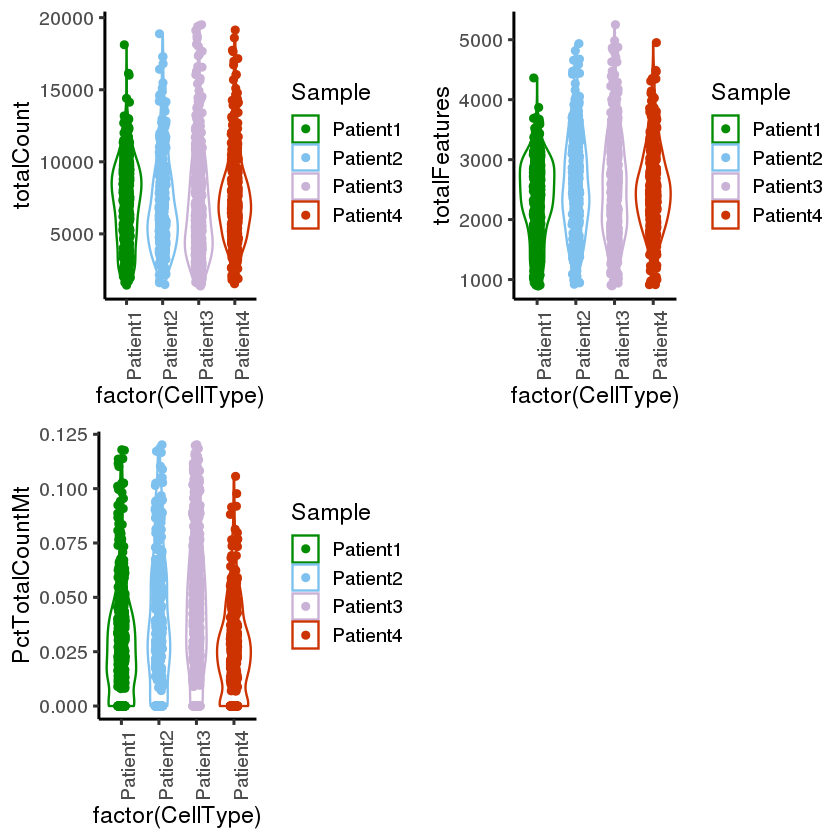

In [70]:
#plots after filtering
df <- data.frame(Cell=colnames(cdScFilt), CellType=cdScFilt$Sample, totalFeatures=cdScFilt$total_features_by_counts, totalCount=cdScFilt$total_counts, PctTotalCountMt=cdScFilt$pct_counts_Mt, Sample=cdScFilt$Sample)
p1 <- ggplot(df, aes(factor(CellType),totalCount,colour=Sample))
p1 <- p1 + geom_violin() + geom_jitter(height = 0, width = 0.1) + theme_classic(base_size = 14) + scale_colour_manual(values=c_sample_col) +
  theme(axis.text.x=element_text(angle=90, hjust=1))
p2 <- ggplot(df, aes(factor(CellType),PctTotalCountMt,colour=Sample))
p2 <- p2 + geom_violin() + geom_jitter(height = 0, width = 0.1) + theme_classic(base_size = 14) + scale_colour_manual(values=c_sample_col) +
  theme(axis.text.x=element_text(angle=90, hjust=1))
p3 <- ggplot(df, aes(factor(CellType),totalFeatures,colour=Sample))
p3 <- p3 + geom_violin() + geom_jitter(height = 0, width = 0.1) + theme_classic(base_size = 14) + scale_colour_manual(values=c_sample_col) +
  theme(axis.text.x=element_text(angle=90, hjust=1))
multiplot(p1,p2,p3,cols = 2)

In [40]:
save.image()

# 4. Classification of cell cycle phase<a name='section4' />

The prediction method used here is described by [Scialdone et al. (2015)](http://www.sciencedirect.com/science/article/pii/S1046202315300098) to classify cells into cell cycle phases based on the gene expression data. Using a training dataset, the sign of the difference in expression between two genes was computed for each pair of genes. Pairs with changes in the sign across cell cycle phases were chosen as markers. Cells in a test dataset can then be classified into the appropriate phase, based on whether the observed sign for each marker pair is consistent with one phase or another. We do the cell cycle classification before gene filtering as this provides more precise cell cycle phase classifications. This approach is implemented in the Cyclone function using a pre-trained set of marker pairs for human data. Some additional work is necessary to match the gene symbols in the data to the Ensembl annotation in the pre-trained marker set.



In [41]:
cdScFiltAnnot <- cdScFilt

<font color=red>__edits required human or mouse__</font>

In [42]:
#human
#sample.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))
#anno <- select(org.Hs.eg.db, keys=as.character(rownames(cdScFiltAnnot)), keytype="SYMBOL", column="ENSEMBL")

#mouse
sample.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))
anno <- select(org.Mm.eg.db, keys=as.character(rownames(cdScFiltAnnot)), keytype="SYMBOL", column="ENSEMBL")


'select()' returned 1:many mapping between keys and columns


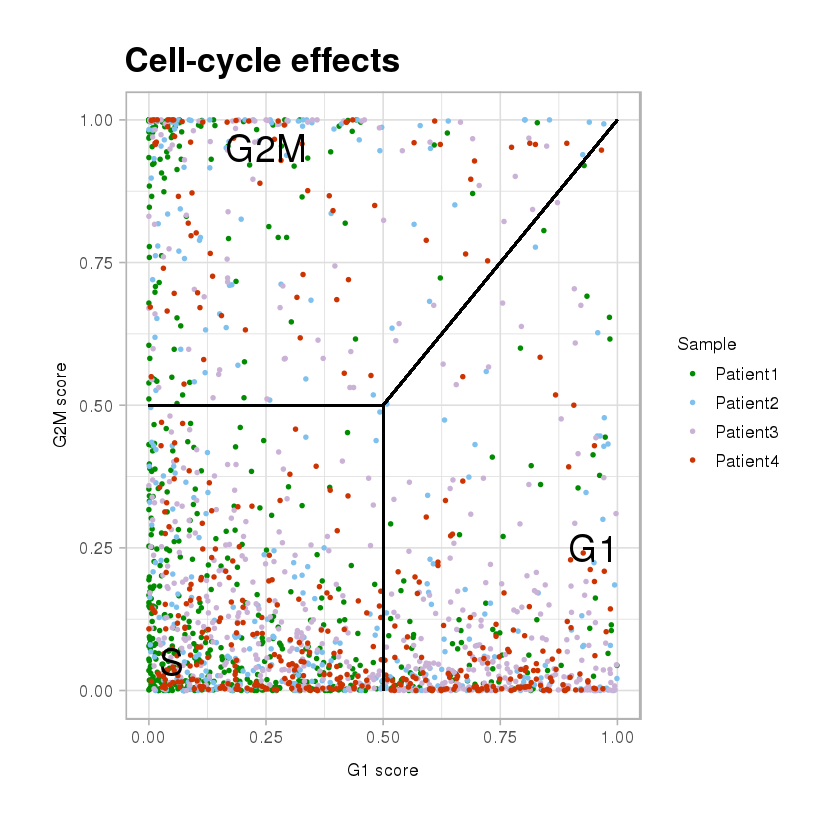

In [73]:
ensembl <- anno$ENSEMBL[match(as.character(rownames(cdScFiltAnnot)), anno$SYMBOL)]
assignments <- cyclone(cdScFiltAnnot, sample.pairs, gene.names=ensembl)
df <- data.frame(x=assignments$score$G1, y=assignments$score$G2M, Sample=colData(cdScFilt)$Sample)
 p<-ggplot(data=df, aes(x=x,y=y,color=Sample)) + 
    geom_point(size=0.5)+
    xlab("G1 score")+
    ylab("G2M score")+
    ylim(0,1)+
    xlim(0,1)+
    ggtitle("Cell-cycle effects")+
    theme_light(base_size=15)+
    theme(axis.title.x = element_text(size=10, vjust=-2),
          axis.text.x  = element_text( size=10),
          axis.title.y = element_text( size=10,vjust=2),
          axis.text.y  = element_text( size=10)) +
    theme(plot.margin=unit(c(1,1,1.5,1.2),"cm"))+
    theme(legend.text=element_text(size=10),#size of legend
          legend.title=element_text(size=10), 
          plot.title = element_text(size=20, face="bold")) +
    scale_colour_manual(values=c_sample_col) + 
    #scale_color_discrete(name=legend.title)+
    geom_segment(aes(x = 1/2, y = 0, xend=1/2, yend=1/2),colour="black") + 
    geom_segment(aes(x = 0, y = 1/2, xend=1/2, yend=1/2),colour="black") +
    geom_segment(aes(x = 1/2, y = 1/2, xend=1, yend=1),colour="black") +
    annotate("text", x=0.05, y=0.05, label="S", size=8)+
    annotate("text", x=0.95, y=0.25, label="G1", size=8)+
    annotate("text", x=0.25, y=0.95, label="G2M", size=8)
print(p)

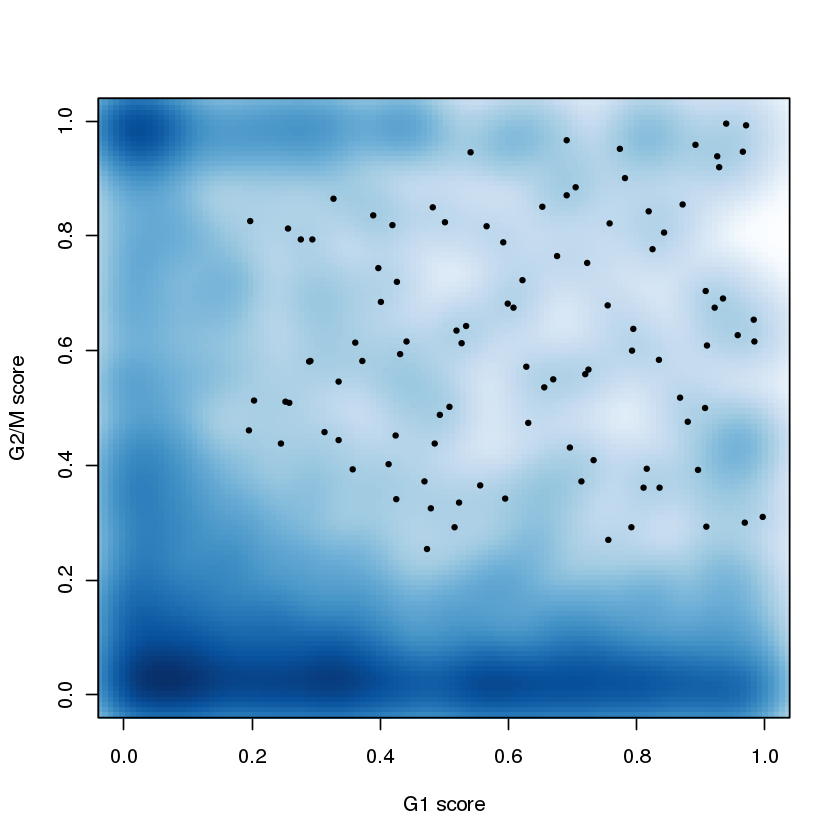

In [74]:
smoothScatter(assignments$score$G1, assignments$score$G2M, xlab="G1 score", ylab="G2/M score", pch=16, cex=0.6)

__Background Cell Cycle Analysis__
- Cells are classified as being in G1 phase (not in cell division aka cell cycle) if their G1 score is above 0.5 and greater than the G2/M score.
- Cells are classified as being in S phase (synthesis of DNA, replication) if neither score is above 0.5.
- Cells are classified as being in G2/M phase (gap between DNA synthesis and mitosis) if their G2/M score is above 0.5 and greater than the G1 score.
 
The cell-cycle status of cells can be a significant confounding factor in some datasets i.e. clusters forming on the basis of cell cycle status instead of other biological factors of interest. The goal at this stage is only to assess the cell cycle status of cells not to try normalise it away.

This method would be less accurate for data that are substantially different from those used in the training set, e.g., due to the use of a different protocol. This dataset uses UMI counts, which has an entirely different set of biases, e.g., 3’-end coverage only, no length bias, no amplification noise. These new biases (and the absence of expected biases) may interfere with accurate classification of some cells. So there is some uncertainty with this analysis. 


Nevertheless we need to keep in mind that there could be quite high cell-cycle effect which might confound the dataset. To avoid problems from misclassification, no processing of this dataset by cell cycle phase will be done here.

__This Dataset's Cell Cycle result__
It looks like majority of the cells have a high __G1__ score indicating that the cells are __somewhat__ going through cell-cycle stages. Generally if they are on G1 stage, then they are not in cell-cycle stage and if on G2/M then they are cell-cycle stages. But here they are in S, which is the synthesis phase indicating DNA is being replicated. <font color=red>__edits required to this cell__</font>

In [75]:
## Assigning cell-cycle stages to the scater object
colData(cdScFilt)$CellCycle <- assignments$phases
colData(cdScFiltAnnot)$CellCycle <- assignments$phases
cdScFilt

class: SingleCellExperiment 
dim: 33538 1825 
metadata(0):
assays(2): counts logcounts
rownames(33538): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(9): symbol is_feature_control_Mt ... total_counts
  log10_total_counts
colnames(1825): CGAGTGCTCAGCTAGT-4 TTCTGTATCCACACAA-4 ...
  TTGCATTTCACCGGGT-1 TGGGCTGGTCAACCTA-3
colData names(39): barcode Sample ... pct_counts_in_top_500_features
  CellCycle
reducedDimNames(0):
spikeNames(0):

In [46]:
save.image('data.RData')

# 5. Filtering out low-abundance genes<a name='section5' />

The goal is to keep genes that will be good features to discriminate the cells. 

Low-abundance genes are problematic as zero or near-zero counts do not contain enough information for reliable statistical inference ([Bourgon et al., 2010](http://www.pnas.org/content/107/21/9546)). In addition, the discreteness of the counts may interfere with downstream statistical procedures, e.g., by compromising the accuracy of continuous approximations. 

The more low frequency, low expression genes the more noise. 

These genes are likely to be dominated by drop-out events ([Brennecke et al., 2013](https://www.nature.com/articles/nmeth.2645)), which limits their usefulness in later analyses. Removal of these genes improves discreteness and reduces the amount of computational work without major loss of information.

Generally in scRNA-seq low-abundance genes are defined as those with an average count below a filter threshold of 1. But 10X Chromium is based on UMI counts, which are lower but better quality counts, so setting the threshold to 1 would filter a large number of cells unfairly. 

<font color=red>In the analysis below we go through an iterative process using the figure below, starting with 0.01 to assess what cutoff to use.
To check whether the chosen threshold is suitable, we examine the distribution of log-means across all genes (Figure below). Generally for higher number of cells there is a peak on the right hand side that represents the bulk of moderately expressed genes while in the middle there is a rectangular component that corresponds to lowly expressed genes. The filter threshold should cut the distribution at some point along the rectangular component to remove the majority of low-abundance genes. As the blue line repsresents in the figure below, it cuts the counts at the rectangular component. Generally 9,000 - 14,000 genes is good (mouse) and 7,500-14,000 for human.
</font>

In [76]:
# gene counts for both cut offs
ave.counts <- rowMeans(counts(cdScFilt))
keepA <- ave.counts >= 0.01
keepB <- ave.counts >= 0.02
print(paste0('Log10 av count >=0.01 leaves ',as.character(sum(keepA)), ' genes '))
print(paste0('Log10 av count >=0.02 leaves ',as.character(sum(keepB)), ' genes '))


[1] "Log10 av count >=0.01 leaves 13194 genes "
[1] "Log10 av count >=0.02 leaves 11892 genes "


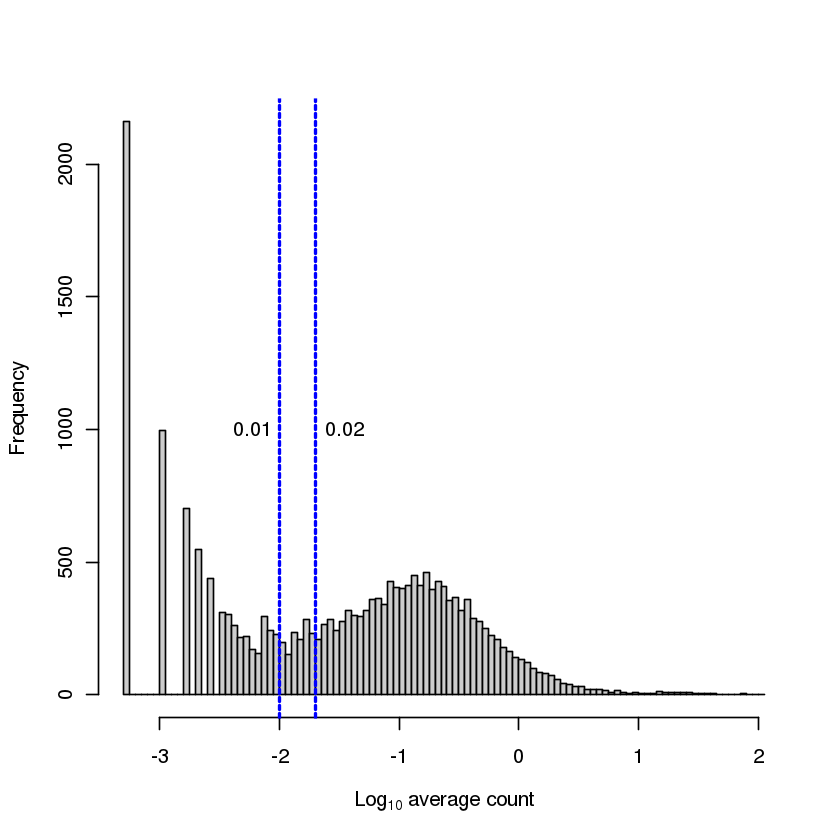

In [77]:
# plot of both cut offs
hist(log10(ave.counts), breaks=100, main="", col="grey80",
     xlab=expression(Log[10]~"average count"))
abline(v=log10(0.02), col="blue", lwd=2, lty=2)
text(log10(0.035),1000, "0.02")
abline(v=log10(0.01), col="blue", lwd=2, lty=2)
text(log10(0.006), 1000, "0.01")


<font color=red>__Decide cutoff__</font>

In [79]:
ave.counts <- rowMeans(counts(cdScFilt))
keep <- ave.counts >= 0.01
print(paste0('Log10 av count adjustment now leaves ',as.character(sum(keep)), ' genes '))
#sum(keep)

[1] "Log10 av count adjustment now leaves 13194 genes "


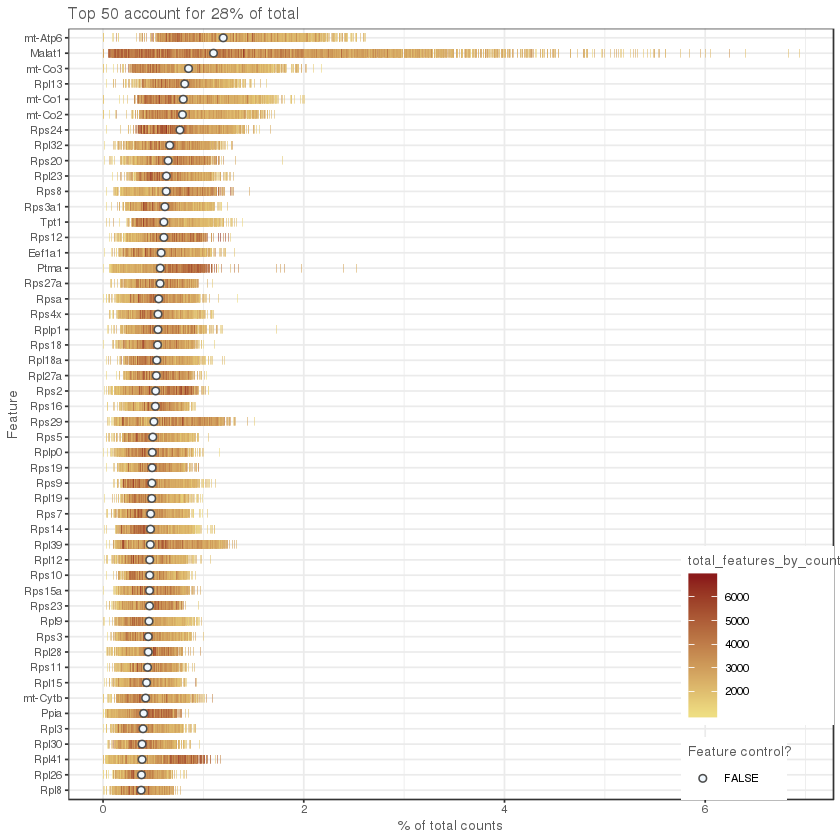

In [50]:
plotHighestExprs(cdScFiltAnnot)

__Check identities of the most highly expressed genes before filtering them__. This should generally be dominated by constitutively expressed transcripts, such as those for ribosomal or mitochondrial proteins. The presence of other classes of features may be cause for concern if they are not consistent with expected biology. For example, the absence of ribosomal proteins and/or the presence of their pseudogenes are indicative of suboptimal alignment.

Plot shows percentage of total counts (per cell) assigned to the top 50 most highly-abundant features in the dataset.

For each feature, each bar represents the percentage assigned to that feature for a cell, while the circle represents the average across all cells. Bars are coloured by the total number of expressed features in each cell, while circles are coloured according to whether the feature is labelled as a control feature.



<font color=red>__Do the topmost genes appear to agree with the biology?__</font>

<font color=red>__NOTE permanent change to cdScFiltAnnot next!__</font>

This mean-based filter tends to be less aggressive. A gene will be retained as long as it has sufficient expression in any subset of cells. Genes expressed in fewer cells require higher levels of expression in those cells to be retained, but this is not undesirable as it avoids selecting uninformative genes (with low expression in few cells) that contribute little to downstream analyses, e.g., HVG detection or clustering. In contrast, the “at least n” filter depends heavily on the choice of n. With n = 10, a gene expressed in a subset of 9 cells would be filtered out, regardless of the level of expression in those cells. This may result in the failure to detect rare subpopulations that are present at frequencies below n. While the mean-based filter will retain more outlier-driven genes, this can be handled by choosing methods that are robust to outliers in the downstream analyses.
Thus, we apply the mean-based filter to the data by subsetting the SCESet object as shown below. 

In [80]:
cdScFilt <- cdScFilt[keep,]
cdScFiltAnnot <- cdScFilt
cdScFiltAnnot

class: SingleCellExperiment 
dim: 13194 1825 
metadata(0):
assays(2): counts logcounts
rownames(13194): AL669831.5 LINC00115 ... AL354822.1 AC240274.1
rowData names(9): symbol is_feature_control_Mt ... total_counts
  log10_total_counts
colnames(1825): CGAGTGCTCAGCTAGT-4 TTCTGTATCCACACAA-4 ...
  TTGCATTTCACCGGGT-1 TGGGCTGGTCAACCTA-3
colData names(39): barcode Sample ... pct_counts_in_top_500_features
  CellCycle
reducedDimNames(0):
spikeNames(0):

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


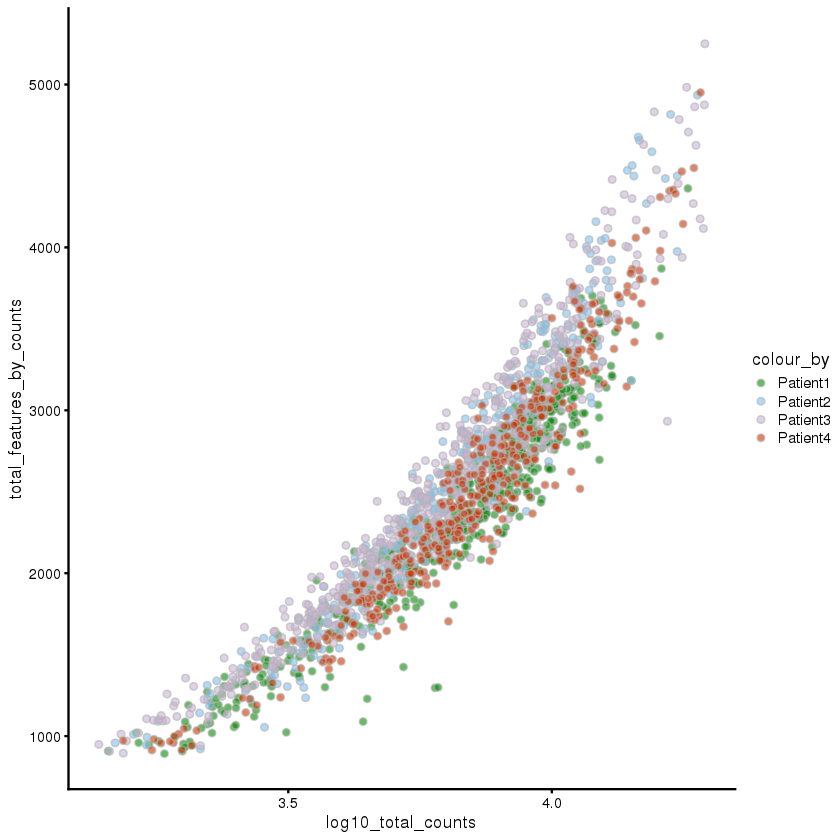

In [81]:
plotColData(cdScFilt, x="log10_total_counts",y="total_features_by_counts", colour_by = "Sample") + scale_fill_manual(values=c_sample_col) 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


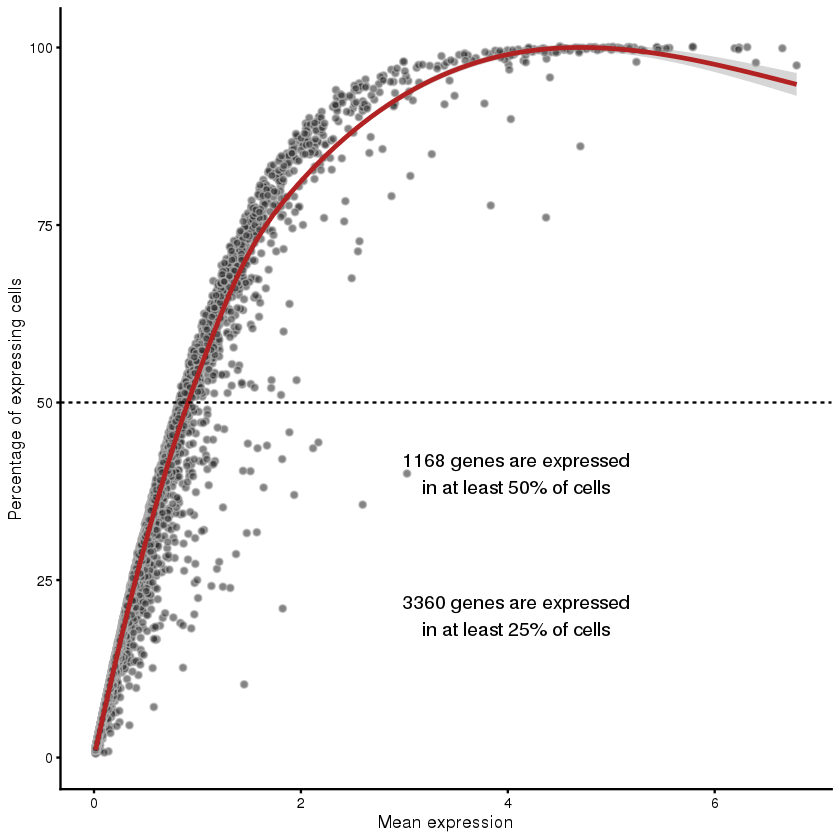

In [82]:
plotExprsFreqVsMean(cdScFiltAnnot)

__Frequency of the cells versus mean expression.__ Preferably at least 1000 genes will be expressed in 50% of the cells. These uniformly expressed genes are not helpful in disciminating cells, but if the number of genes expressed in >50% is low, that means the dataset quality is not great because too many dropouts.

In [54]:
save.image('data.RData')

# 6. Normalization of read counts<a name='section6' />
Single cell RNA-seq data requires different normalisation to bulk data methods (e.g. DESeq2) because scRNA-seq is very sparse. Here the deconvolution based method will be used.

__Further detail on the deconvolution method to deal with zero counts:__ 
Read counts are subject to differences in capture efficiency and sequencing depth between cells ([Stegle et al., 2015](https://www.nature.com/articles/nrg3833)). Normalization is required to eliminate these cell-specific biases prior to downstream quantitative analyses. In bulk data this is often done by assuming that most genes are not differentially expressed (DE) between cells. Any systematic difference in count size across the non-DE majority of genes between two cells is assumed to represent bias and is removed by scaling. More specifically, “size factors” are calculated that represent the extent to which counts should be scaled in each library. Single-cell data can be problematic due to the dominance of low and zero counts. To overcome this, counts from many cells are pooled to increase the count size for accurate size factor estimation ([Lun et al., 2016](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7)). Pool-based size factors are then “deconvolved” into cell-based factors for cell-specific normalization.

In [83]:
cdScFiltAnnot <- computeSumFactors(cdScFiltAnnot, sizes=c(10, 50, 100, 150))
summary(sizeFactors(cdScFiltAnnot))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1175  0.6728  0.9386  1.0000  1.2652  3.0557 

<font color=red>__If pool size is too big then in some datasets an error will be called ("estimated negative size factor"). In that case go down to smaller pool sizes (e.g. 100, 150, 200, 250, 300). If still not low enough keep going reducing the size (50,100,150,200,300,400). But this can also give "estimated negative size factor". Adjustments to these step sizes can be tried if the tSNE plots indicate that library size is dominating cluster selection.__</font>


In [84]:
DF <- data.frame(VAR1=sizeFactors(cdScFiltAnnot), VAR2=cdScFiltAnnot$total_counts/1e6)
model = lm(VAR2 ~ VAR1, DF)
summary(model)


Call:
lm(formula = VAR2 ~ VAR1, data = DF)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0034400 -0.0006346 -0.0001271  0.0005131  0.0048120 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.790e-04  5.481e-05   8.739   <2e-16 ***
VAR1        6.669e-03  4.966e-05 134.293   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0009909 on 1823 degrees of freedom
Multiple R-squared:  0.9082,	Adjusted R-squared:  0.9081 
F-statistic: 1.803e+04 on 1 and 1823 DF,  p-value: < 2.2e-16


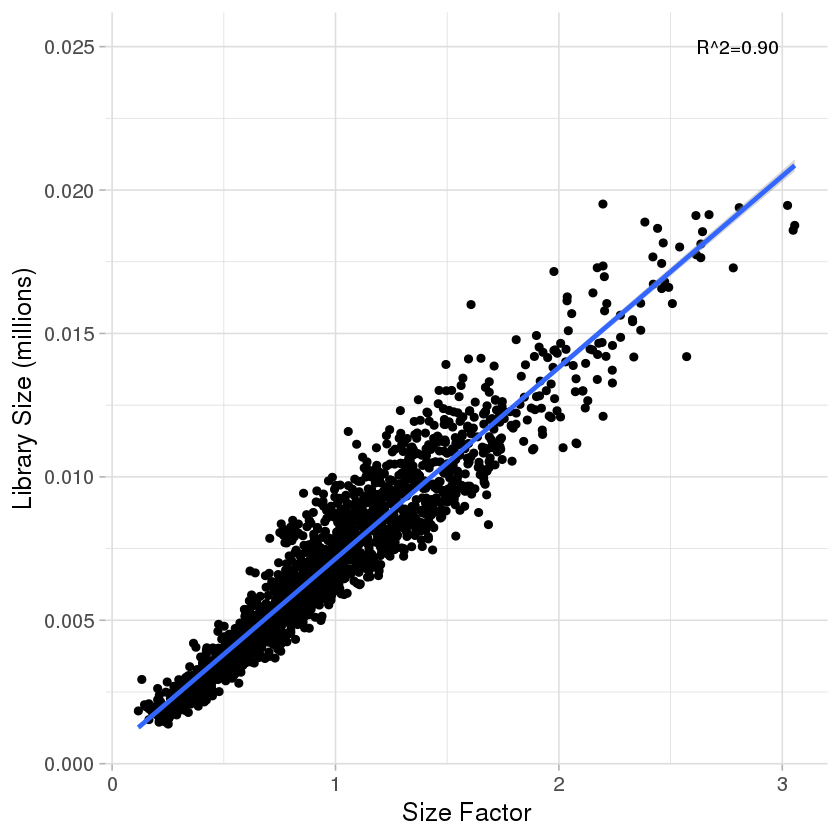

In [86]:
sp = ggplot(DF, aes(x=VAR1, y=VAR2))
sp + geom_point() + stat_smooth(method=lm) + theme_light(base_size=15) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5)) +  
              xlab("Size Factor") + 
              ylab("Library Size (millions)")+
              annotate("text", label="R^2=0.90", x=2.8, y=0.025)

If the size factors are tightly correlated with the library sizes for all cells this would suggests that the systematic differences between cells are primarily driven by differences in capture efficiency or sequencing depth. Any DE between cells would yield a non-linear trend between the total count and size factor, and/or increased scatter around the trend.

With a high R^2 value, the size factors are very tightly correlated with the library size. I calculate the size factor normization and put it in a slot of `SummarizedExperiment` object.


__Applying the size factors to normalize gene expression:__

The count data are used to compute normalized log-expression values for use in downstream analyses. Each value is defined as the log-ratio of each count to the size factor for the corresponding cell, after adding a prior count of 1 to avoid undefined values at zero counts. Division by the size factor ensures that any cell-specific biases are removed. If spike-in-specific size factors are present in sce, they will be automatically applied to normalize the spike-in transcripts separately from the endogenous genes.

### Re-calculate the CPM normalization using size factors

Recalculate the `counts-per-million` for these cells. This is because large number of genes have been filtered out which would have impacted the library size when CPM was calcualted with unfiltered data. Now, as the number of genes have been reduced, so is the library size. 

In [87]:
exprs(cdScFiltAnnot) <- log2(calculateCPM(cdScFiltAnnot, use_size_factors = TRUE) + 1)

Setting the parameter `use.size.factors = TRUE` enables the use of step sizes calculated in the above pool based method.

The log-transformation provides some measure of variance stabilization ([Law et al., 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4053721/)), so that high-abundance genes with large variances do not dominate downstream analyses. The computed values are stored as an exprs matrix in addition to the other assay elements.

## Checking for important technical factors

Check whether there are technical factors that contribute substantially to the heterogeneity of gene expression. If so, the factor may need to be regressed out to ensure that it does not inflate the variances or introduce spurious correlations. For a dataset with a simple experimental design there are no plate or batch effects to examine. However, there could be other technical factors like the cell-cycle effect or dropouts. The plots below show before and after normalisation.

In [88]:
cdScFiltAnnot

class: SingleCellExperiment 
dim: 13194 1825 
metadata(0):
assays(2): counts logcounts
rownames(13194): AL669831.5 LINC00115 ... AL354822.1 AC240274.1
rowData names(9): symbol is_feature_control_Mt ... total_counts
  log10_total_counts
colnames(1825): CGAGTGCTCAGCTAGT-4 TTCTGTATCCACACAA-4 ...
  TTGCATTTCACCGGGT-1 TGGGCTGGTCAACCTA-3
colData names(39): barcode Sample ... pct_counts_in_top_500_features
  CellCycle
reducedDimNames(0):
spikeNames(0):

In [89]:
names(colData(cdScFiltAnnot))

[1] "barcode"                                       
 [2] "Sample"                                        
 [3] "total_features_by_counts_endogenous"           
 [4] "log10_total_features_by_counts_endogenous"     
 [5] "total_counts_endogenous"                       
 [6] "log10_total_counts_endogenous"                 
 [7] "pct_counts_endogenous"                         
 [8] "pct_counts_in_top_50_features_endogenous"      
 [9] "pct_counts_in_top_100_features_endogenous"     
[10] "pct_counts_in_top_200_features_endogenous"     
[11] "pct_counts_in_top_500_features_endogenous"     
[12] "total_features_by_counts_feature_control"      
[13] "log10_total_features_by_counts_feature_control"
[14] "total_counts_feature_control"                  
[15] "log10_total_counts_feature_control"            
[16] "pct_counts_feature_control"                    
[17] "pct_counts_in_top_50_features_feature_control" 
[18] "pct_counts_in_top_100_features_feature_control"
[19] "pct_counts_in_top_200_features_feature_control"
[20] "pct_counts_in_top_500_features_feature_control"
[21] "total_features_by_counts_Mt"                   
[22] "log10_total_features_by_counts_Mt"             
[23] "total_counts_Mt"                               
[24] "log10_total_counts_Mt"                         
[25] "pct_counts_Mt"                                 
[26] "pct_counts_in_top_50_features_Mt"              
[27] "pct_counts_in_top_100_features_Mt"             
[28] "pct_counts_in_top_200_features_Mt"             
[29] "pct_counts_in_top_500_features_Mt"             
[30] "is_cell_control"                               
[31] "total_features_by_counts"                      
[32] "log10_total_features_by_counts"                
[33] "total_counts"                                  
[34] "log10_total_counts"                            
[35] "pct_counts_in_top_50_features"                 
[36] "pct_counts_in_top_100_features"                
[37] "pct_counts_in_top_200_features"                
[38] "pct_counts_in_top_500_features"                
[39] "CellCycle"

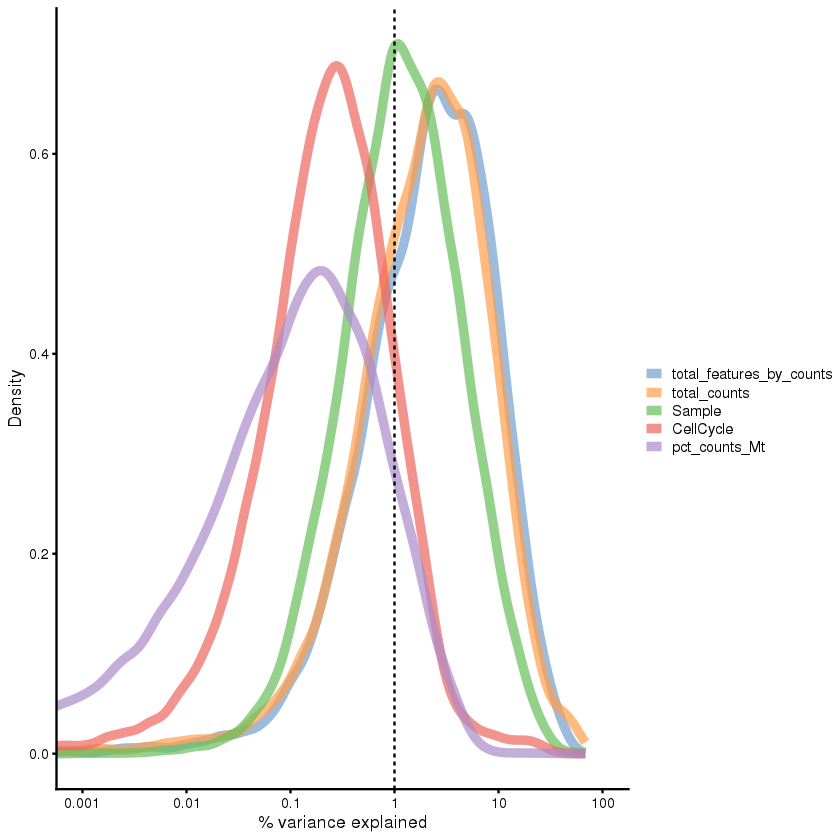

In [90]:
#before normalisation
plotExplanatoryVariables(cdScFiltAnnot, exprs_values = "counts", variables=c("total_features_by_counts", "total_counts", "CellCycle","pct_counts_Mt", "Sample"))


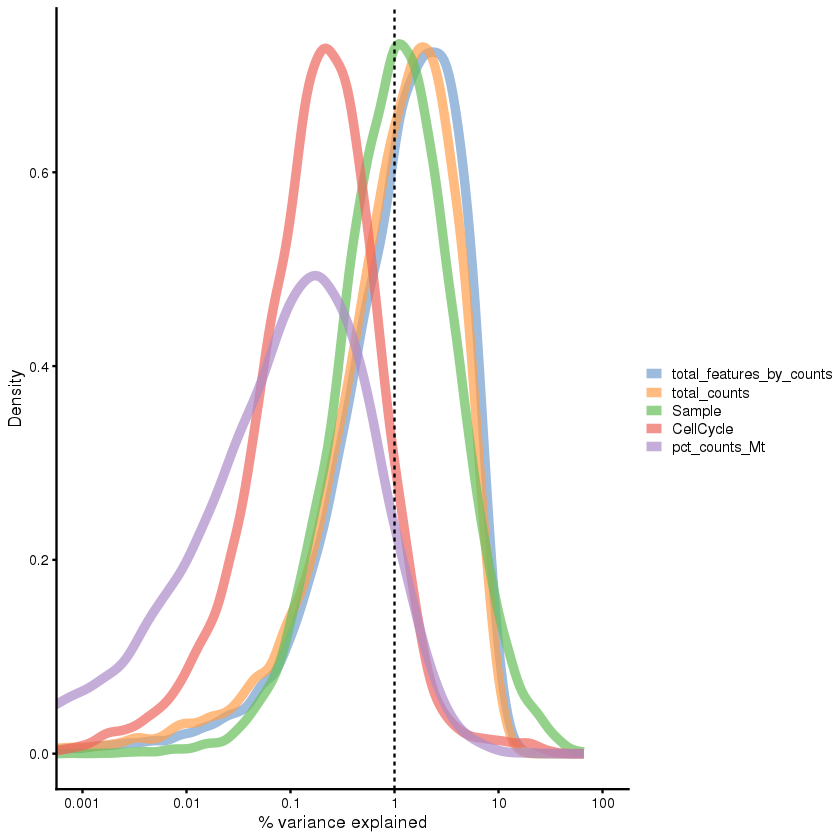

In [91]:
#after normalisation
plotExplanatoryVariables(cdScFiltAnnot, variables=c("total_features_by_counts", "total_counts", "CellCycle", "pct_counts_Mt", "Sample"))

__Assessing this plot.__ 
Typically the number of total features (genes) and total counts explain the major variability in scRNA-seq datasets. This indicates that cells vary significantly based on number of genes that they are expressing. 

Number of total features explaining majority of the variability is a common issue in single-cell RNA-seq. This could be due to the sparsity of the data. The PCA plot might be separating cells just because they have very different number of features expressed in total.

However, this would not confound the t-SNE plot which would take the non-linear relationship between the variables. As long as the peaks for _total_counts_ and _total_feature_by_counts_ are below 10 this is normal.

In the cell-cycle plot shown earlier and this plot help establish the importance of the cell-cycle effect.


# 7. Identifying genes for feature selection (HVG)<a name='section7' />

The goal is to identify genes that will be good features to discriminate the cells. In this step, the dataset is filtered to keep only genes that are “informative” of the variability in the data. Highly Variable Genes (HVG) are the ones driving heterogeneity across the population of cells. 

__Detail__ HVG identification requires estimation of the variance in expression for each gene, followed by decomposition of the variance into biological and technical components. HVGs are then identified as those genes with the largest biological components. This avoids prioritizing genes that are highly variable due to technical factors, such as sampling noise during RNA capture and library preparation.

In the recent implementation of `seurat`, Rahul Satija took a slightly different approach for HVG calculation. They calculate the variance and mean for each gene in the dataset (storing this in `object@hvg.info`), and sorts genes by their variance/mean ratio (VMR). They have observed that for large-cell datasets with unique molecular identifiers, selecting highly variable genes (HVG) simply based on VMR is an efficient and robust strategy. 

But in the implementation used here a trend is fitted to the variance estimates of the endogenous genes, using the `use.spikes=FALSE` setting as shown below. This assumes that the majority of genes are not variably expressed, such that the technical component dominates the total variance for those genes. The fitted value of the trend is then used as an estimate of the technical component. 

__span:__ Low-abundance genes with mean log-expression below `min.mean` are not used in trend fitting, to preserve the sensitivity of span-based smoothers at moderate-to-high abundances. It also protects against discreteness, which can interfere with estimation of the variability of the variance estimates and accurate scaling of the trend. The default threshold is chosen based on the point at which discreteness is observed in variance estimates from Poisson-distributed counts. For heterogeneous droplet data, a lower threshold of 0.001-0.01 should be used.

In [92]:
var.fit <- trendVar(cdScFiltAnnot, method="loess", use.spikes=FALSE, min.mean=1.0)
#or scater default
#var.fit <- trendVar(cdScFiltAnnot, method="loess", use.spikes=FALSE)#default
#var.fit <- trendVar(cdScFiltAnnot, method="loess", use.spikes=FALSE, min.mean=0.1)
var.out <- decomposeVar(cdScFiltAnnot, var.fit)
var.out

DataFrame with 13194 rows and 6 columns
                         mean             total                bio
                    <numeric>         <numeric>          <numeric>
AL669831.5  0.292413514882491  1.99034767547437   0.12256771069805
LINC00115  0.0823733117556895  0.59071644032303 0.0645601120446372
AL645608.3  0.553846919173677   3.7237733200891  0.186097643226517
AL645608.1  0.226198410062083  1.57852496443396  0.133691408953466
SAMD11       1.48135378126176  9.29639140577559  0.567231780948354
...                       ...               ...                ...
AC011043.1  0.198055496510842   1.3494896050325 0.0844178163860865
AL592183.1  0.137653095415761 0.982883638780493  0.103629840233183
AC007325.4  0.148623515793144  1.01923733257323 0.0699104001138796
AL354822.1  0.266868059934152  1.82490181947289  0.120292455627165
AC240274.1   0.39116568217776  2.66049513671405  0.161939540289976
                        tech              p.value                 FDR
                   

We assess the suitability of the trend fitted to the endogenous variances by examining whether it is consistent with the variances. The trend passes through or close to most of the endogenous gene variances, indicating that our assumption (that most genes have low levels of biological variability) is valid. This strategy exploits the large number of endogenous genes to obtain a stable trend. 

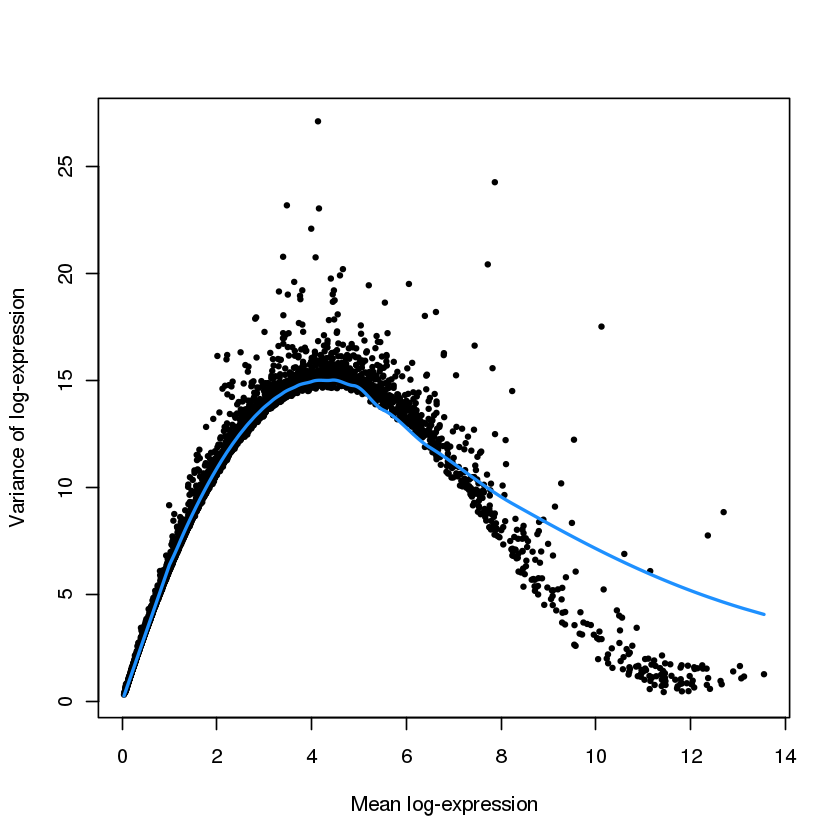

In [93]:
plot(var.out$mean, var.out$total, pch=16, cex=0.6, xlab="Mean log-expression", ylab="Variance of log-expression")
o <- order(var.out$mean)
lines(var.out$mean[o], var.out$tech[o], col="dodgerblue", lwd=2)

Ideally the plot above would look like the mountain, where it would have rise in the middle but then drop off at the end (low variance for highly expressed genes). The trend line would follow it as well. 

HVG are defined as genes with biological components that are significantly greater than zero at a false discovery rate (FDR) of 5%. These genes are interesting as they drive differences in the expression profiles between cells, and should be prioritized for further investigation. Here a gene is considered to be a HVG if it has a biological component greater than or equal to 0.5. For transformed expression values on the log2 scale, this means that the average difference in true expression between any two cells will be at least 2-fold. (This reasoning assumes that the true log-expression values are Normally distributed with variance of 0.5. The root-mean-square of the difference between two values is treated as the average log2-fold change between cells and is equal to unity.) The results are ranked by the biological component to focus on genes with larger biological variability. HVG can number anywhere between 200-5000 depending on the complexity of the dataset and depth of sequencing https://www.embopress.org/doi/10.15252/msb.20188746

In [94]:
hvg.out <- var.out[which(var.out$FDR <= 0.05 & var.out$bio >= 0.5),]
hvg.out <- hvg.out[order(hvg.out$bio, decreasing=TRUE),]
print(paste0('Number of HVG using this setting is ' ,as.character(nrow(hvg.out))))


[1] "Number of HVG using this setting is 351"


In [95]:
head(rownames(hvg.out),20)

[1] "TIMP1"    "KRT81"    "TPT1"     "FN1"      "SAA1"     "IFI27"   
 [7] "TAGLN"    "MT1X"     "TGM2"     "KRT19"    "AKAP12"   "HIST1H4C"
[13] "RARRES1"  "MT1E"     "CENPF"    "SERPINE1" "TFPI2"    "IGFBP5"  
[19] "CCDC80"   "IGFBP4"

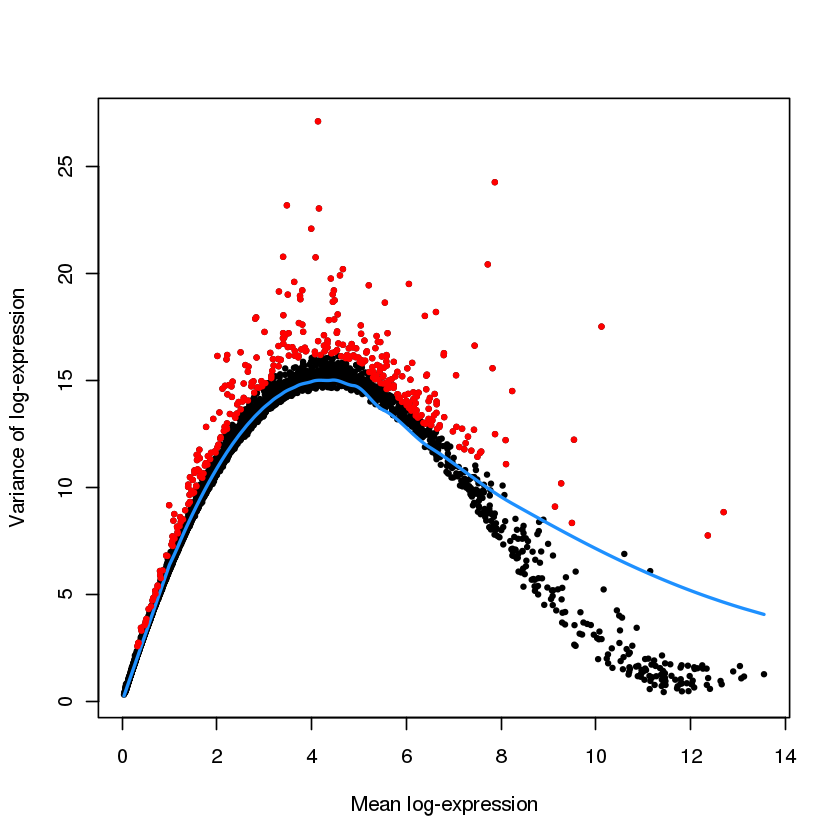

In [96]:
plot(var.out$mean, var.out$total, pch=16, cex=0.6, xlab="Mean log-expression",
     ylab="Variance of log-expression")
o <- order(var.out$mean)
lines(var.out$mean[o], var.out$tech[o], col="dodgerblue", lwd=2)
points(var.out[rownames(hvg.out),]$mean, var.out[rownames(hvg.out),]$total, col="red", pch=16, cex=0.6)

Plot showing the HVG in red. 

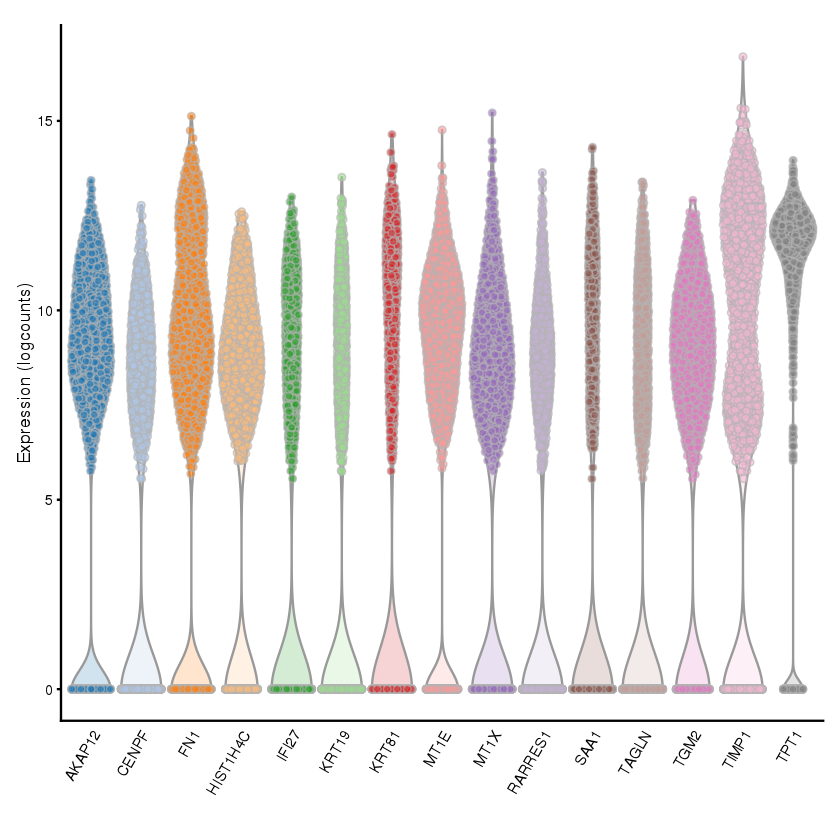

In [97]:
## Plotting the top 15 HVGs
plotExpression(cdScFiltAnnot, rownames(hvg.out)[1:15])

In [98]:
write.table(file="HVG.xls", hvg.out, sep="\t", quote = FALSE, col.names = NA)
head(hvg.out, 20)

DataFrame with 20 rows and 6 columns
                     mean            total              bio             tech
                <numeric>        <numeric>        <numeric>        <numeric>
TIMP1    7.86709632160163 24.2773947708697  14.521193749592 9.75620102127771
KRT81    4.13544171576234 27.1241059275866 12.1073346733104 15.0167712542762
TPT1     10.1176738428334 17.5285486496608  10.511871297697 7.01667735196379
FN1      7.71819936714799 20.4358311308409 10.4574221250506 9.97840900579023
SAA1      3.4789139910594 23.1964357545348 8.66293417245518 14.5335015820797
...                   ...              ...              ...              ...
SERPINE1 8.23324339691744 14.5150273844362 5.25662237460787  9.2584050098283
TFPI2    5.20727951678479 19.4585282871293 5.22059050012898 14.2379377870003
IGFBP5   2.01236389552981   16.15402191995 5.21329316855077 10.9407287513992
CCDC80   5.54682811043964 18.6483909082604  5.0573412987002 13.5910496095602
IGFBP4   4.59939001023172 19.9203468614

__Final Notes__ There are alternative approaches for determining the HVG, sspecially those based on Coefficient of Variance. The method used here, the variance of the log-expression values, avoids genes with strong expression in only one or two cells. This ensures that the set of top HVGs is not dominated by genes with (mostly uninteresting) outlier expression patterns.

However, it has been mentioned that fitting the trendline to endogenous genes might not always be a good idea.


In [22]:
save.image('data.RData')

# 8. Analysis of the dataset using highly variable genes HVG<a name='section8' />
    1. PCA
    2. t-SNE
    3. UMAP


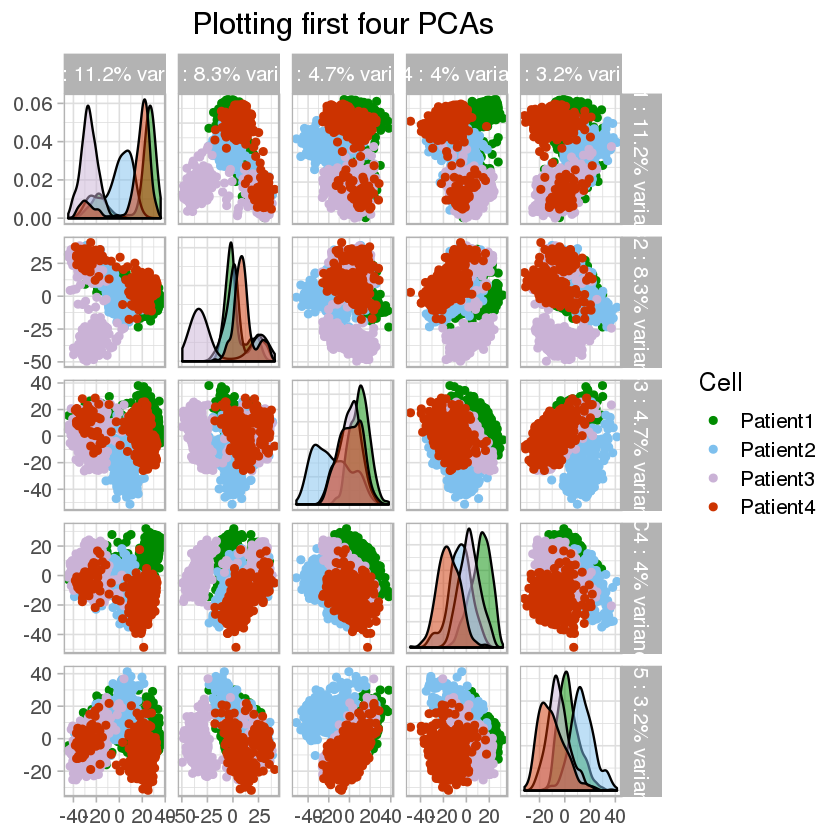

In [99]:
rowVarsSorted <- exprs(cdScFiltAnnot)[rownames(hvg.out),]
FinalPCAData <- t(rowVarsSorted)
pcaPRComp <- prcomp(FinalPCAData)
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

#pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
#rownames(pca_var_out) <- rownames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)
nColToDisplay = 5
df <- as.data.frame(pcaPRComp$x)
df$Cell=as.factor(colData(cdScFiltAnnot)$Sample)
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+   
    theme(plot.title = element_text(hjust = 0.5))

for(i in 1:p$nrow) {
  for(j in 1:p$ncol){
    p[i,j] <- p[i,j] + 
        scale_colour_manual(values=c_sample_col)+
        scale_fill_manual(values=alpha(c(c_sample_col),0.5))  
  }
}

    
print(p)

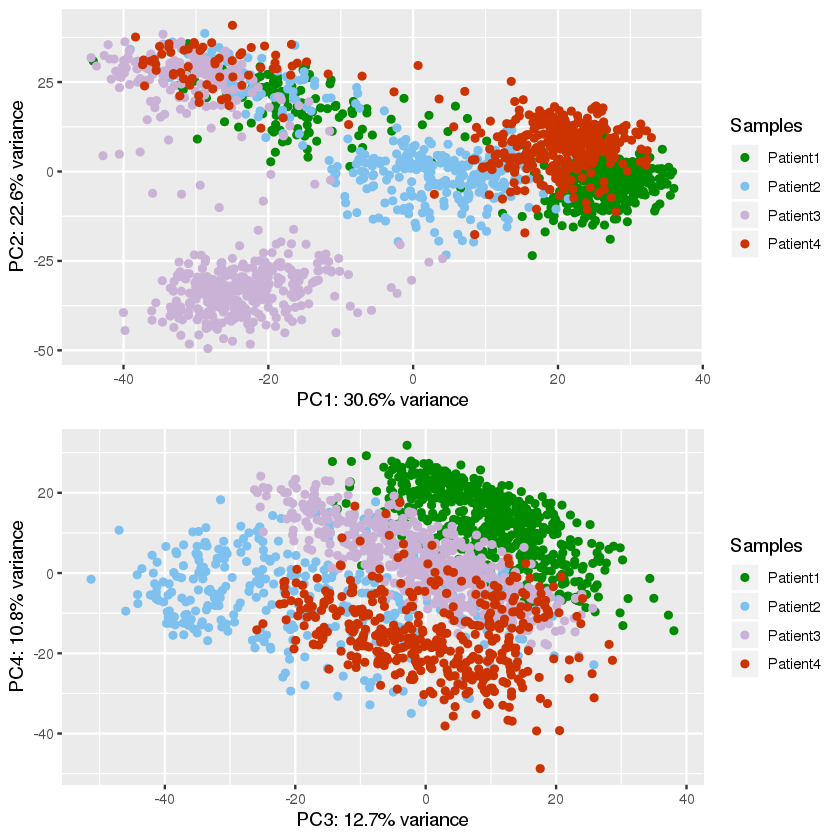

In [100]:
#PC 1v2
df_out <- as.data.frame(pcaPRComp$x)
df_out$group <- sapply( strsplit(as.character(row.names(df)), "_"), "[[", 1 )
Samples=as.factor(colData(cdScFiltAnnot)$Sample)
pp12<-ggplot(df_out,aes(x=PC1,y=PC2,color=Samples ))
pp12<-pp12+geom_point()+ 
        scale_colour_manual(values=c_sample_col)+
    xlab(paste0("PC1: ",round(pca_var_percent_first10[1],1),"% variance")) +
    ylab(paste0("PC2: ",round(pca_var_percent_first10[2],1),"% variance"))
#pca_var_percent_first10[1] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

#PC 3v4
df_out <- as.data.frame(pcaPRComp$x)
df_out$group <- sapply( strsplit(as.character(row.names(df)), "_"), "[[", 1 )
Samples=as.factor(colData(cdScFiltAnnot)$Sample)
pp34<-ggplot(df_out,aes(x=PC3,y=PC4,color=Samples ))
pp34<-pp34+geom_point()+ 
        scale_colour_manual(values=c_sample_col)+
    xlab(paste0("PC3: ",round(pca_var_percent_first10[3],1),"% variance")) +
    ylab(paste0("PC4: ",round(pca_var_percent_first10[4],1),"% variance"))

multiplot(pp12,pp34, cols=1)


### t-SNE plot with only the HVG:

<font color=red>__Note t-SNE calculated next. Everytime you run this step the t-SNE plot will look different.__</font>

In [84]:
tsne_out <- Rtsne(as.matrix(pcaPRComp$x[,1:14]),check_duplicates = FALSE, pca = FALSE,
             perplexity=30, theta=0.01, dims=2, num_threads = 4)
Rep <- as.factor(colData(cdScFiltAnnot)$Sample)
counts <- colData(cdScFiltAnnot)$total_counts


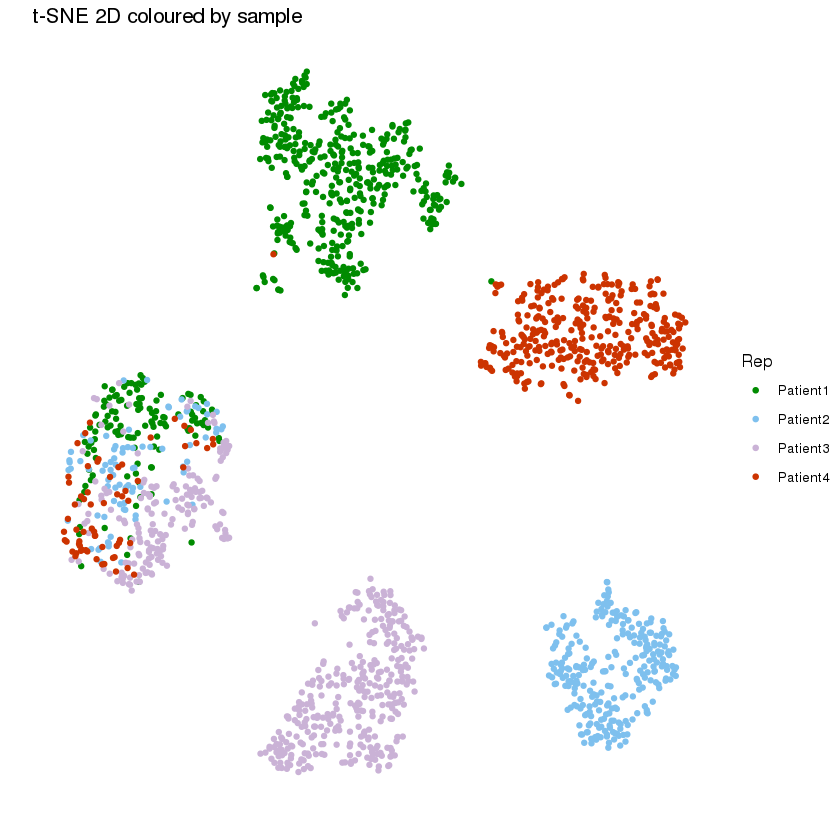

In [101]:
p2 <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=Rep)) +
     geom_point(size=0.75) +
     guides(colour = guide_legend(override.aes = list(size=0.8))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D coloured by sample") +
     theme_classic(base_size=10) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank()) +
          scale_fill_manual(values=c_sample_col) +
         scale_colour_manual(values=c_sample_col)
p2

### Running UMAP for data visualization

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

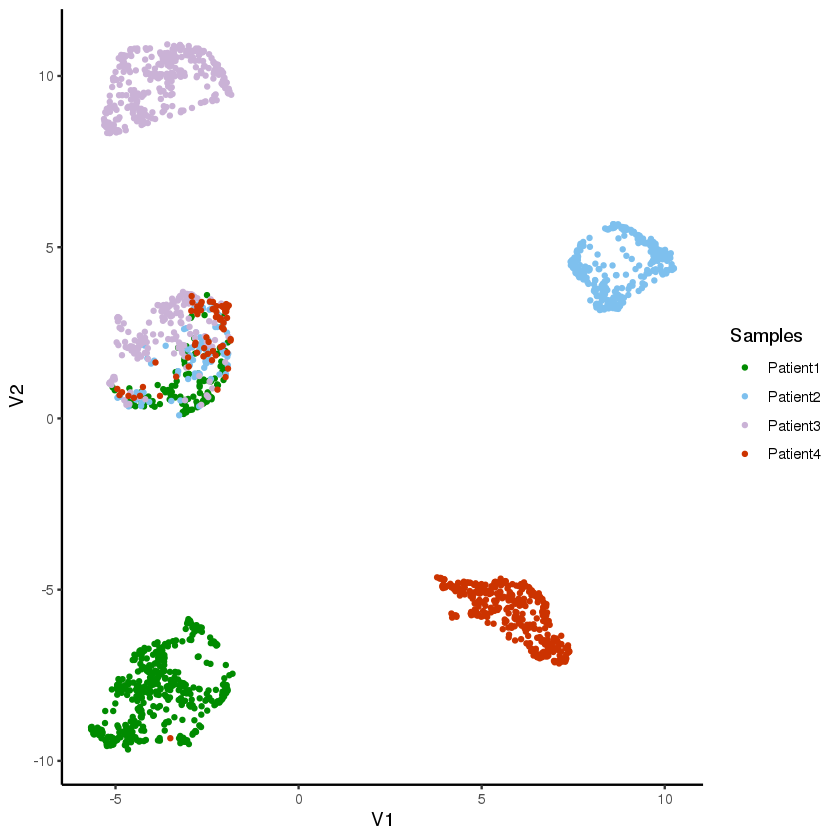

In [102]:
embedding <- umap(pcaPRComp$x[,1:14])
as.tibble(embedding$layout) %>%
  mutate(Samples = colData(cdScFiltAnnot)$Sample) %>%
  ggplot(aes(V1, V2, color=Samples)) +  geom_point(size=0.75) + theme_classic() +scale_colour_manual(values=c_sample_col)

In [ ]:
save.image('data.RData')

# 9. Clustering cells<a name='section9' />
The goal is to split the cells in the dataset into clusters, such that:
1. the cells in the same cluster are as similar as possible,
2. the cells in different clusters are highly distinct

There are numerous methods of clustering; dynamic-cut-tree, k-means, k-medoids, GMM, GP-LVM and so on. Here the dynamic-cut-tree will be used.

### Dynamic Cut Tree Description
Hierarchical clustering is a widely used method for detecting clusters in genomic data. Clusters are defined by cutting branches off the dendrogram. A common but inflexible method uses a constant height cutoff value; this method exhibits suboptimal performance on complicated dendrograms. The Dynamic Tree Cut R library implements novel dynamic branch cutting methods for detecting clusters in a dendrogram depending on their shape. Compared to the constant height cutoff method, these techniques offer the following advantages: (1) they are capable of identifying nested clusters; (2) they are flexible --- cluster shape parameters can be tuned to suit the application at hand; (3) they are suitable for automation; and (4) they can optionally combine the advantages of hierarchical clustering and partitioning around medoids, giving better detection of outliers.

### Clustering cells into putative subpopulations
Hierarchical clustering is performed on the Euclidean distances between cells, using Ward’s criterion to minimize the total variance within each cluster. This yields a dendrogram that groups together cells with similar expression patterns across the chosen genes. 

Clusters are explicitly defined by applying a dynamic tree cut (Langfelder et al., 2008)[https://academic.oup.com/bioinformatics/article/24/5/719/200751] to the dendrogram. This exploits the shape of the branches in the dendrogram to refine the cluster definitions, and is more appropriate than cutree for complex dendrograms. Greater control of the empirical clusters can be obtained by manually specifying cutHeight in cutreeDynamic.

An alternative approach is to cluster on a matrix of distances derived from correlations (e.g., as in `quickCluster`). This is more robust to noise and normalization errors, but is also less sensitive to subtle changes in the expression profiles.

In [103]:
chosen.exprs <- logcounts(cdScFiltAnnot[rownames(hvg.out),])
my.dist <- dist(t(chosen.exprs))
my.tree <- hclust(my.dist, method = "ward.D2")
my.clusters <- unname(cutreeDynamic(my.tree, distM=as.matrix(my.dist), verbose=0))
print(paste0('Number of clusters'))
levels(as.factor(my.clusters))

[1] "Number of clusters"


[1] "1" "2" "3" "4" "5" "6" "7"

In [116]:
cdScFiltAnnot$Clusters <- as.factor(my.clusters)

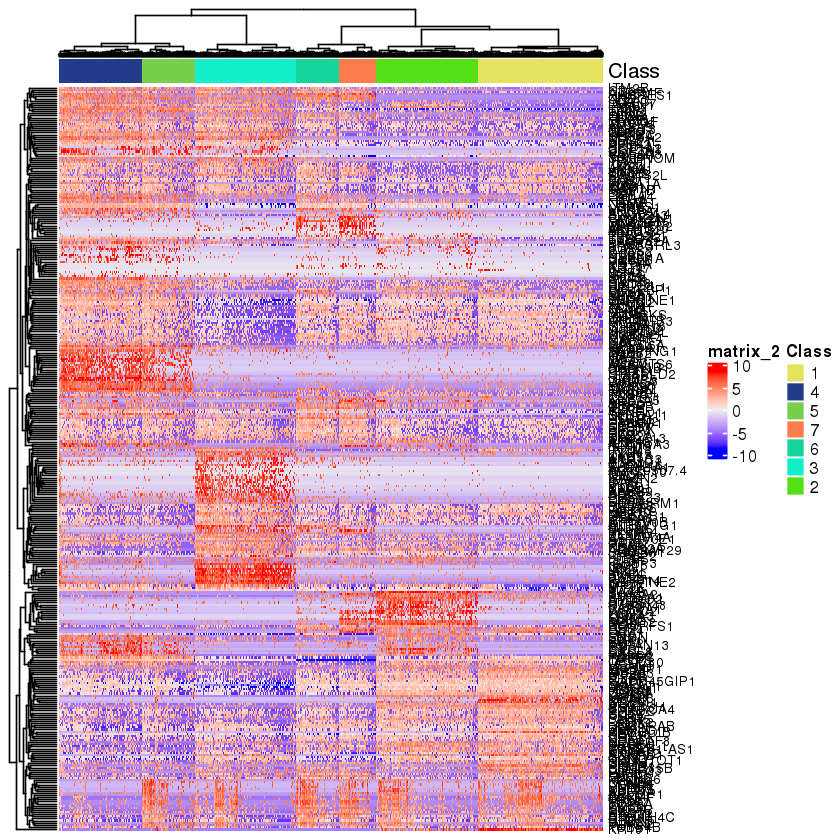

In [105]:
heat.vals <- chosen.exprs - rowMeans(chosen.exprs)

#clust.col <- rainbow(max(my.clusters))
#heatmap.2(heat.vals, col=bluered, symbreak=TRUE, trace='none', cexRow=0.3,
#    ColSideColors=clust.col[my.clusters], Colv=as.dendrogram(my.tree))

df = data.frame(Class = as.factor(my.clusters))
ha = HeatmapAnnotation(df = df)
#ha = HeatmapAnnotation(df = df, col = list(Condition = c("MC_A" =  "dodgerblue", "MC_B"= "firebrick", "MC_C"="forestgreen", "MC_D"="gold")))
Heatmap(heat.vals , top_annotation = ha, show_column_names=FALSE, cluster_rows = TRUE, clustering_method_columns = "ward.D2", row_names_gp = gpar(fontsize = 8))

In [106]:
pdf("heatmap.pdf", width=20, height=40)
Heatmap(heat.vals , top_annotation = ha, show_column_names=FALSE, cluster_rows = TRUE, clustering_method_columns = "ward.D2", row_names_gp = gpar(fontsize = 8))
dev.off()

png 
  2

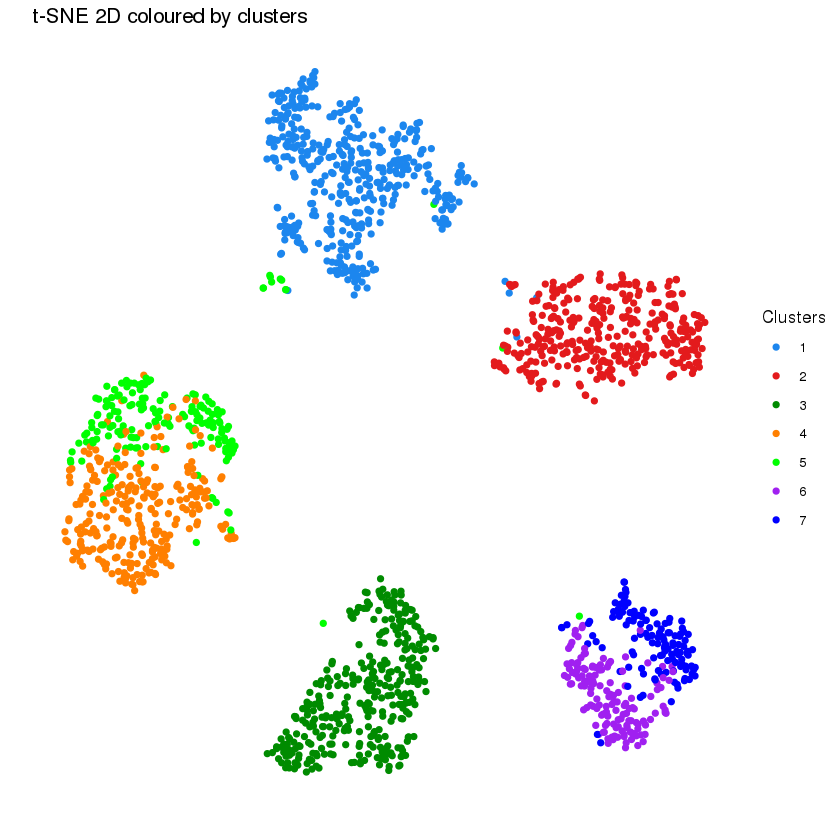

In [107]:
## t-SNE with cluster allocation
Clusters <- as.factor(my.clusters)

p1 <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=Clusters)) +
     geom_point(size=1.0) +
     guides(colour = guide_legend(override.aes = list(size=1))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D coloured by clusters") +
     theme_classic(base_size=10) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank()) + scale_color_manual(values=c_clust_col)
p1


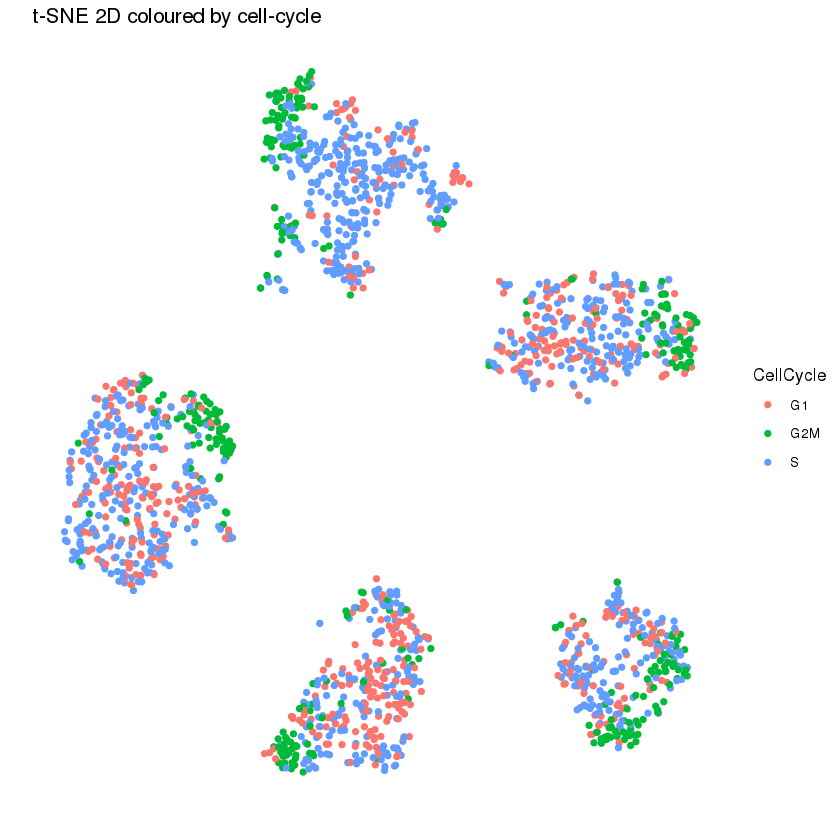

In [108]:
## t-SNE with Cell-cycle
CellCycle <- as.factor(cdScFiltAnnot$CellCycle)

p2 <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=CellCycle)) +
     geom_point(size=1.0) +
     guides(colour = guide_legend(override.aes = list(size=1))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D coloured by cell-cycle") +
     theme_classic(base_size=10) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank()) 
p2

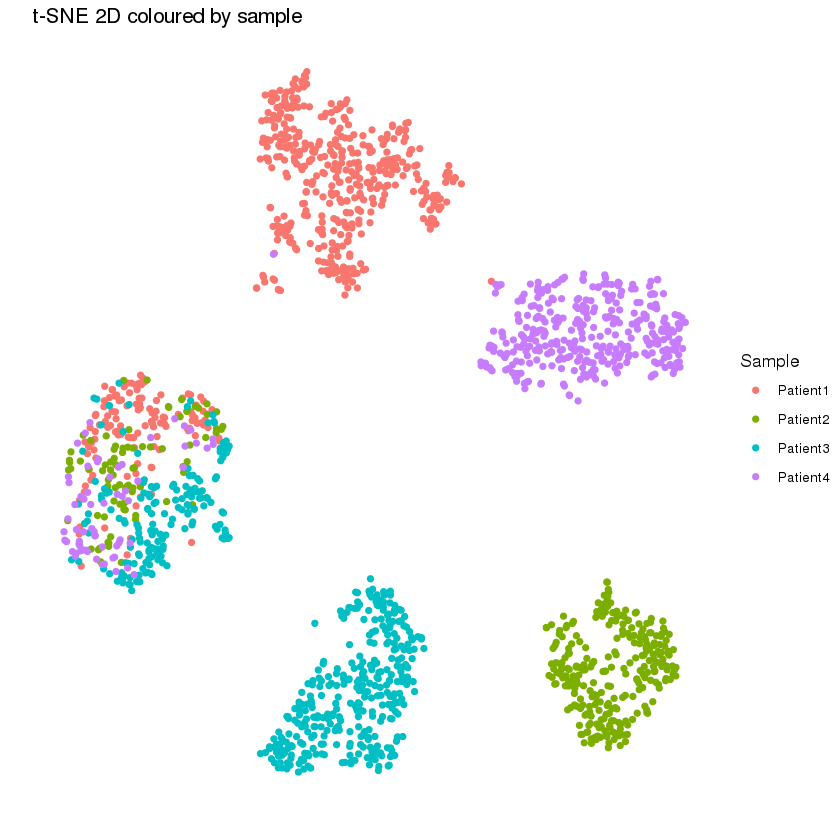

In [109]:
## t-SNE with Sample
Sample <- as.factor(cdScFiltAnnot$Sample)

p3 <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=Sample)) +
     geom_point(size=1.0) +
     guides(colour = guide_legend(override.aes = list(size=1))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D coloured by sample") +
     theme_classic(base_size=10) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank()) 
p3

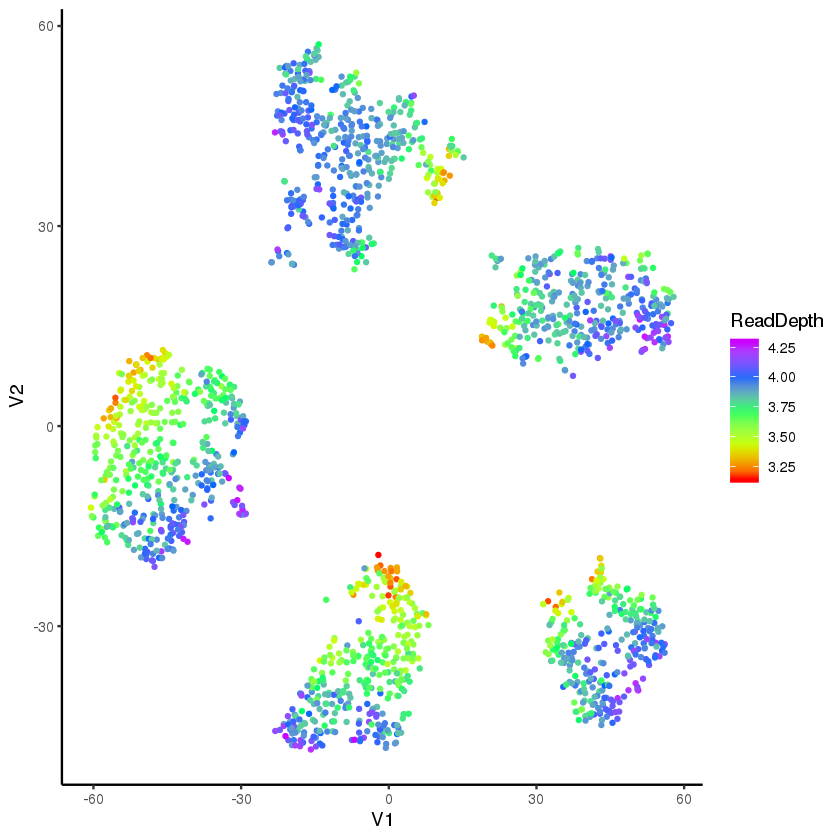

In [110]:
## t-SNE Clustering impacted with read-counts
p4 <- as.tibble(as.data.frame(tsne_out$Y)) %>%
  mutate(ReadDepth = cdScFiltAnnot$log10_total_counts) %>%
  ggplot(aes(V1, V2, color=ReadDepth)) +  geom_point(size=0.75) + theme_classic() +
  scale_colour_gradientn(colours = rainbow(5))
p4

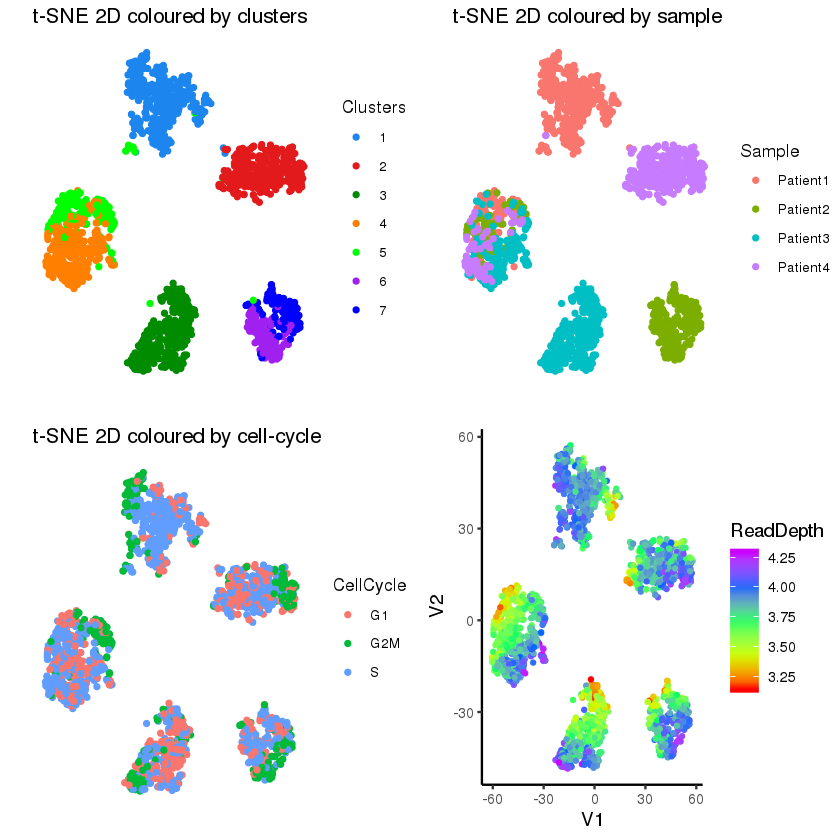

In [111]:
multiplot(p1,p2,p3,p4, cols=2)

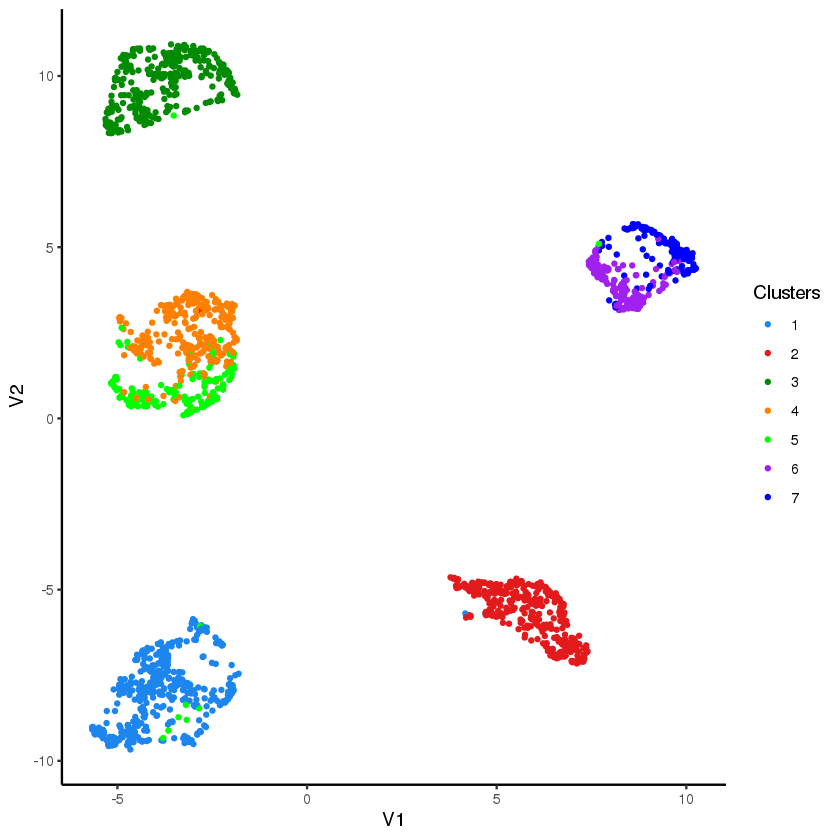

In [112]:
## UMAP with cluster allocation
Clusters <- as.factor(my.clusters)
as.tibble(embedding$layout) %>%
  mutate(Clusters = Clusters) %>%
  ggplot(aes(V1, V2, color=Clusters)) +  geom_point(size=0.75) + theme_classic() + scale_color_manual(values=c_clust_col)

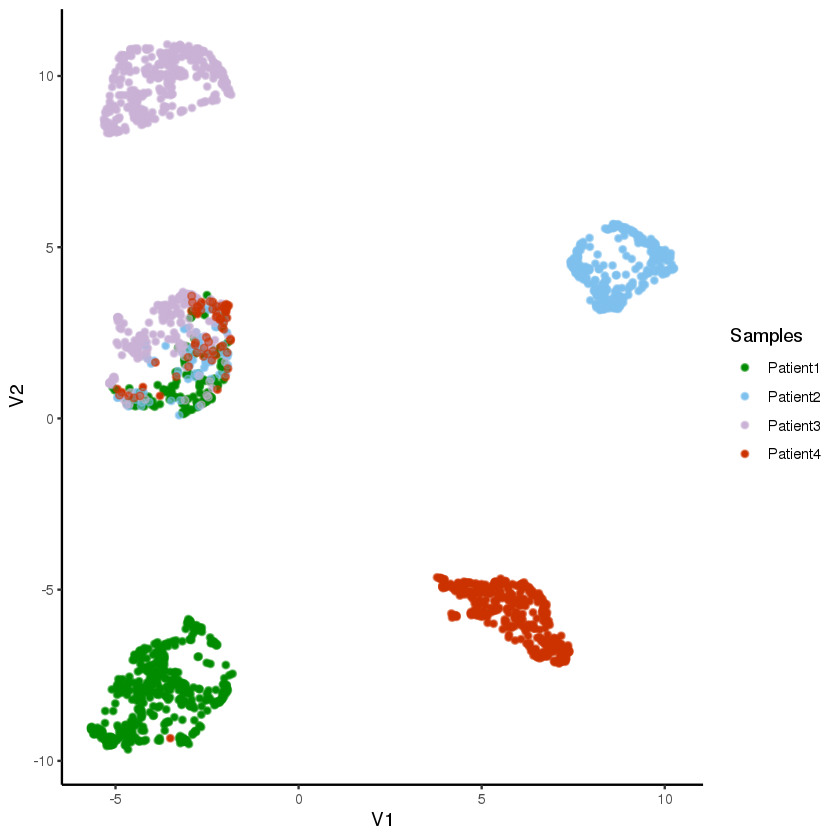

In [113]:
## UMAP with sample colouring
as.tibble(embedding$layout) %>%
  mutate(Samples = colData(cdScFiltAnnot)$Sample) %>%
  ggplot(aes(V1, V2, color=Samples)) +  geom_point(size=0.75)+ geom_point(alpha = 0.5) + theme_classic() +scale_colour_manual(values=c_sample_col)

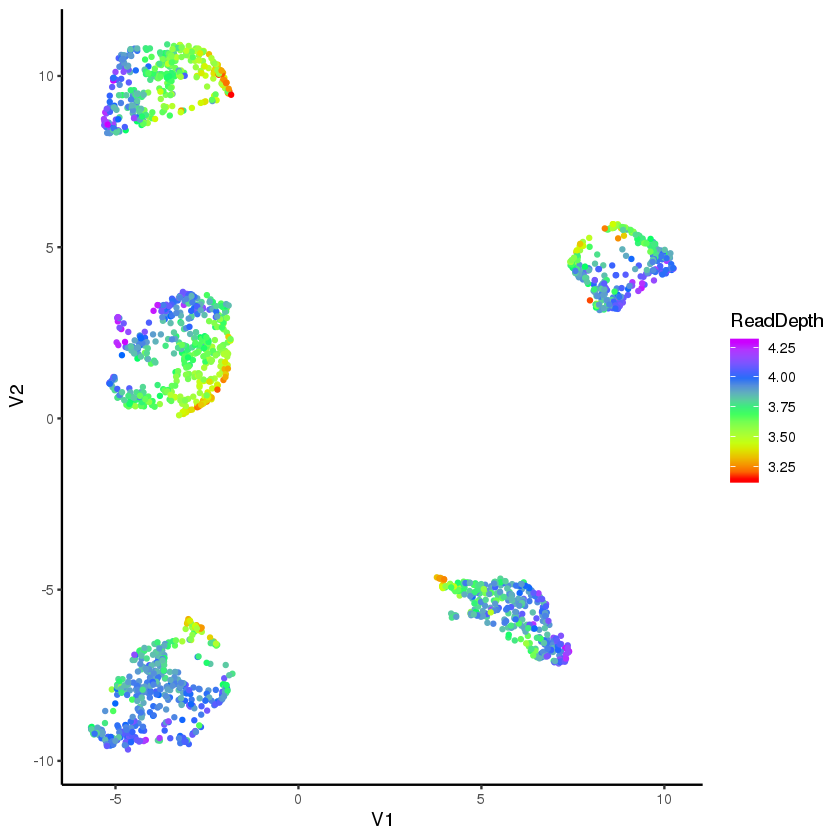

In [114]:
## UMAP view clustering impacted with read counts
as.tibble(embedding$layout) %>%
  mutate(ReadDepth = cdScFiltAnnot$log10_total_counts) %>%
  ggplot(aes(V1, V2, color=ReadDepth)) +  geom_point(size=0.75) + theme_classic() +
  scale_colour_gradientn(colours = rainbow(5))


__Note on interpreting plots__ Ideally clustering will determined by biology and not read count. Likewise the t-SNE and UMAP should not be dominated by the read depth. However, this is a known problem [Hafemeister et. al. 2019](doi: https://doi.org/10.1101/576827).

In [117]:
#how many cells from each sample are in each cluster?
dfTemp<-data.frame(Sample=cdScFiltAnnot$Sample,Clusters=cdScFiltAnnot$Clusters)
table(dfTemp)

          Clusters
Sample       1   2   3   4   5   6   7
  Patient1 414   0   0  34 100   0   0
  Patient2   0   0   0  48  35 143 125
  Patient3   0   0 340 141  33   0   0
  Patient4   4 342   0  57   9   0   0

In [118]:
write.table(table(dfTemp), file="ClusterPopulations.xls", sep="\t", quote=FALSE, col.names=NA)

## Silhouette cluster validation plot
The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters.
Silhouette width can be interpreted as follows:
- Cells with a large Si (almost 1) are very well clustered.
- A small Si (around 0) means that the observation lies between two clusters.
- Cells with a negative Si are probably placed in the wrong cluster. (so cluster is less stable and trustworthy)


### Background to cluster validation
### Internal measures for cluster validation

In this section, we describe the most widely used clustering validation indices. Recall that the goal of partitioning clustering algorithms (Part @ref(partitioning-clustering)) is to split the data set into clusters of objects, such that:

- the objects in the same cluster are as similar as possible,
- and the objects in different clusters are highly distinct
(http://www.sthda.com/english/wiki/print.php?id=241)
(https://www.datanovia.com/en/lessons/cluster-validation-statistics-must-know-methods/)
(http://www.sthda.com/english/wiki/print.php?id=243)


* That is, we want the average distance within cluster to be as small as possible; and the average distance between clusters to be as large as possible.

Internal validation measures often reflect the compactness, the connectedness and the separation of the cluster partitions.

1. Compactness or cluster cohesion: Measures how close are the objects within the same cluster. A lower within-cluster variation is an indicator of a good compactness (i.e., a good clustering). The different indices for evaluating the compactness of clusters are base on distance measures such as the cluster-wise within average/median distances between observations.
2. Separation: Measures how well-separated a cluster is from other clusters. The indices used as separation measures include:
    * distances between cluster centers
    * the pairwise minimum distances between objects in different clusters
3. Connectivity: corresponds to what extent items are placed in the same cluster as their nearest neighbors in the data space. The connectivity has a value between 0 and infinity and should be minimized.

Generally most of the indices used for internal clustering validation combine compactness and separation measures as follow:

$Index = \frac{\alpha * Seperation}{\beta * Compactness}$
where $\alpha$ and $\beta$ are weights.

### Silhouette coefficient

The silhouette analysis measures how well an observation is clustered and it estimates the average distance between clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters.

For each observation $i$, the silhouette width $s_i$ is calculated as follows:

1. For each observation $i$, calculate the average dissimalirty $\alpha_i$ between $i$ and all other points of the cluster which $i$ belongs.
2. For all other clusters $C$, to which $i$ does not belong, calculate the average dissimilarity $d(i,C)$ of $i$ to all observations of $C$. The smallest of these $d(i,C)$ is defined as $b_i = min_C d(i,C)$. The value of $b_i$ can be seen as the dissimilarity between i and its __neighbor__ cluster, i.e. the nearest one to which it does not belong.
3. Finally the silhouette width of the observation $i$ is defined by the formula: $S_i = \frac{(b_i - a_i)}{max(a_i,b_i)}$

Silhouette width can be interpreted as follow:

- Observations with a large Si (almost 1) are very well clustered.
- A small Si (around 0) means that the observation lies between two clusters.
- Observations with a negative Si are probably placed in the wrong cluster.


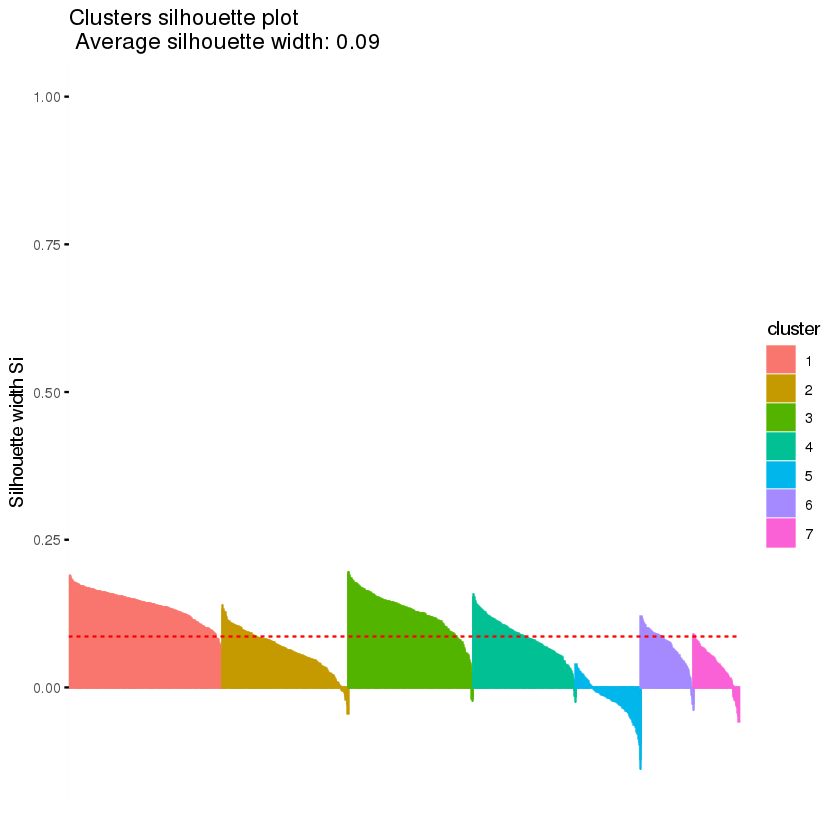

In [119]:
fviz_silhouette(silhouette(my.clusters, my.dist), print.summary = FALSE)

In [105]:
#objects required for Shiny app
reducedDim(cdScFiltAnnot,'tSNE') <- tsne_out$Y
reducedDim(cdScFiltAnnot,'UMAP') <- embedding$layout

In [106]:
cdScFiltAnnot

class: SingleCellExperiment 
dim: 11158 6482 
metadata(0):
assays(2): counts logcounts
rownames(11158): Mrpl15 Lypla1 ... AC149090.1 CAAA01118383.1
rowData names(9): symbol is_feature_control_Mt ... total_counts
  log10_total_counts
colnames(6482): AAACCCAAGCGATGCA-1 AAACCCAAGGTGATAT-1 ...
  TTTGTTGAGGTCCCGT-2 TTTGTTGTCATGGAGG-2
colData names(40): barcode Sample ... CellCycle Clusters
reducedDimNames(2): tSNE UMAP
spikeNames(0):

### Visualizing gene expression in cells
In the following plots we visualize the expression of `XIST` in individual cells. We show the same plot with different colour palletes.

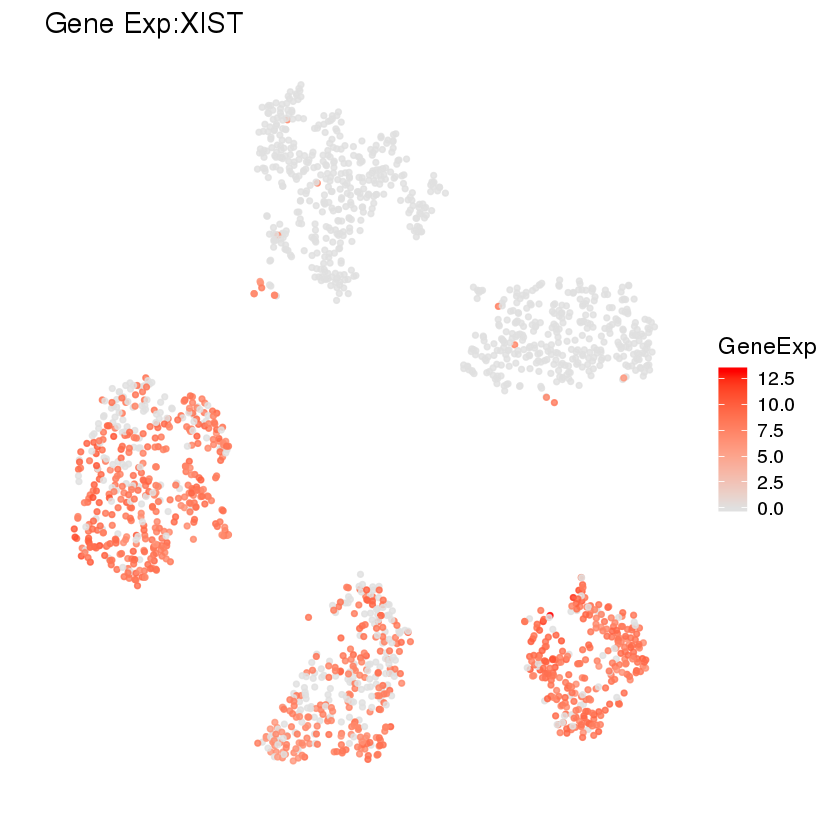

In [125]:
GeneExp <- logcounts(cdScFiltAnnot)['XIST',]
    #GeneName = 'SPN'
    df <- as.data.frame(tsne_out$Y)
    df[,'GeneExp']=logcounts(cdScFiltAnnot)['XIST',]
p1<-     ggplot(df, aes(x=V1, y=V2, GeneExp = GeneExp)) +
      geom_point(size=1.00,aes(colour = GeneExp), alpha=0.8) +
      #scale_colour_viridis_c()+
      scale_colour_gradient(low = "gray88", high = "red")+
      #guides(colour = guide_legend(override.aes = list(size=4))) +
      xlab("") + ylab("") +
      ggtitle(paste0('Gene Exp:','XIST'))+
      theme_classic(base_size=14) +
      theme(strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.text.x      = element_blank(),
            axis.text.y      = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())
p1

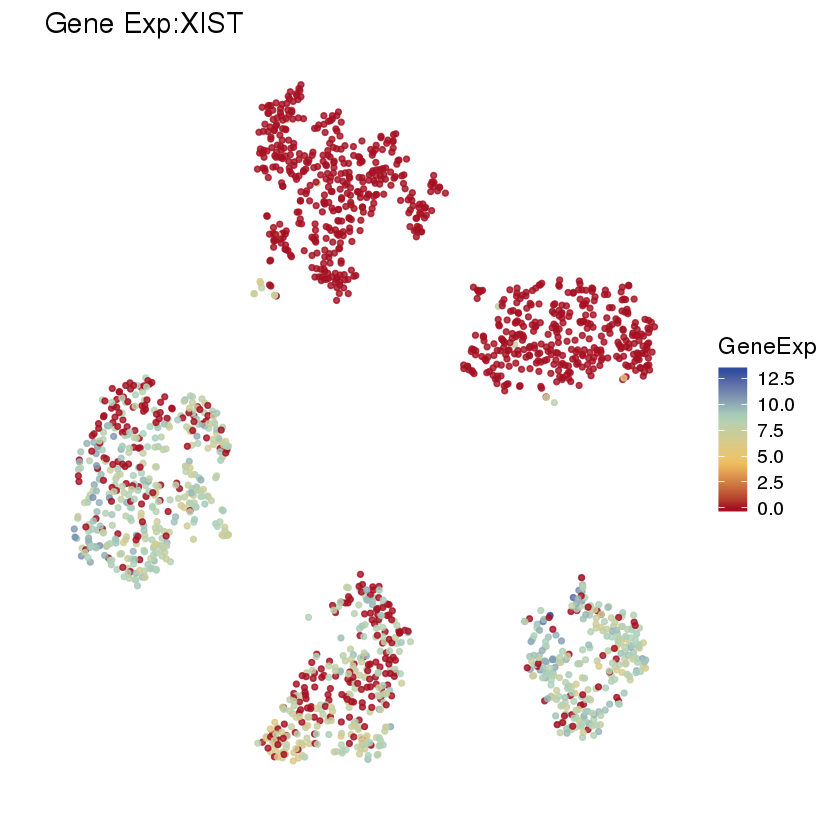

In [126]:
GeneExp <- logcounts(cdScFiltAnnot)['XIST',]
    #GeneName = 'SPN'
    df <- as.data.frame(tsne_out$Y)
    df[,'GeneExp']=logcounts(cdScFiltAnnot)['XIST',]
p1<-     ggplot(df, aes(x=V1, y=V2, GeneExp = GeneExp)) +
      geom_point(size=1.00,aes(colour = GeneExp), alpha=0.8) +
      #scale_colour_viridis_c()+
      scale_colour_gradientn(colours = hcl.colors(n=4, palette = 'RdYlBu'))+
      #guides(colour = guide_legend(override.aes = list(size=4))) +
      xlab("") + ylab("") +
      ggtitle(paste0('Gene Exp:','XIST'))+
      theme_classic(base_size=14) +
      theme(strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.text.x      = element_blank(),
            axis.text.y      = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())
p1

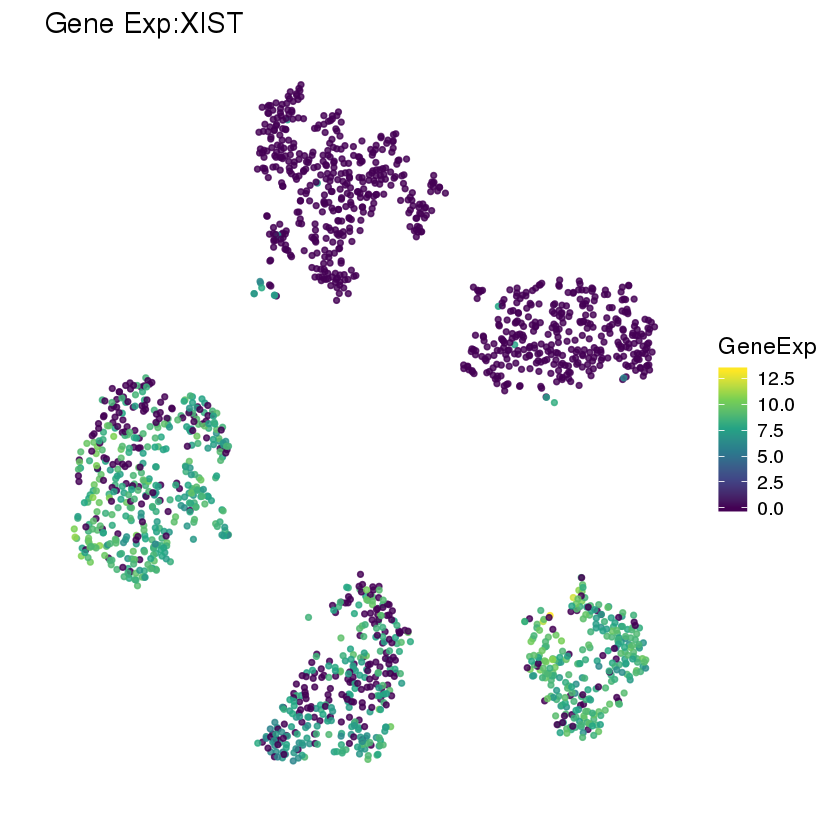

In [127]:
GeneExp <- logcounts(cdScFiltAnnot)['XIST',]
    #GeneName = 'SPN'
    df <- as.data.frame(tsne_out$Y)
    df[,'GeneExp']=logcounts(cdScFiltAnnot)['XIST',]
p1<-     ggplot(df, aes(x=V1, y=V2, GeneExp = GeneExp)) +
      geom_point(size=1.00,aes(colour = GeneExp), alpha=0.8) +
  scale_colour_viridis_c()+
      #scale_colour_gradient(low = "gray88", high = "purple4")+
      #guides(colour = guide_legend(override.aes = list(size=4))) +
      xlab("") + ylab("") +
      ggtitle(paste0('Gene Exp:','XIST'))+
      theme_classic(base_size=14) +
      theme(strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.text.x      = element_blank(),
            axis.text.y      = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())
p1

In [120]:
saveRDS(cdScFiltAnnot,'cdScFiltAnnot.rds')

In [121]:
save.image('data.RData')

# 10. Identifying marker genes for clusters<a name='section10' />

Potential marker genes are identified by taking the top set of DE genes from each pairwise comparison between clusters. The results are arranged into a single output table that allows a marker set to be easily defined for a user-specified size of the top set. For example, to construct a marker set from the top 10 genes of each comparison, one would filter `marker.set` to retain rows with Top less than or equal to 10.

<font color=red>__note any poor clusters in the silhouette plot and consider how trustworthy the marker genes actually are.__</font> 

In [109]:
cluster <- factor(my.clusters)
de.design <- model.matrix(~0 + cluster)
y <- convertTo(cdScFiltAnnot, type="edgeR")
y <- estimateDisp(y, de.design)
fit <- glmFit(y, de.design)
summary(y$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0001   0.0791   0.1909   0.8170   0.5252 102.4000 

In [122]:
clust.col <- rainbow(max(my.clusters))

In [123]:
clusterNumber <- max(my.clusters)
pairwiseComparisonNumber <- choose(clusterNumber,2)
compClusters <- length(levels(as.factor(my.clusters)))-1
endClusters <- (3+length(levels(as.factor(my.clusters)))-2)

In [ ]:
# Set this up if you are running the following code parallel
## setup parallel backend to use many processors

#cores=detectCores()
#cl <- makeCluster(6) #Have choosen 6 cores here
#registerDoParallel(cl)

In [45]:
result.logFC <- result.FDR <- list()


#foreach(i=c(1:(clusterNumber))) %dopar% {
for(i in c(1:(clusterNumber))){
  for(j in c(1:clusterNumber))
  {
    if(i == j){ next }
    print(paste0('In ',i,", in ",j))
    contrast <- numeric(ncol(de.design))
    contrast[i] <- 1
    contrast[j] <- -1
    fit <- edgeR::glmQLFit(y, de.design)
    res <- edgeR::glmQLFTest(fit, contrast = contrast)
    top.tags <- edgeR::topTags(res, n=length(y$design), sort.by="none")

    con.name <- paste0('vs.', levels(cluster)[j])
    result.logFC[[con.name]] <- top.tags$table$logFC
    #names(result1.logFC[[con.name]]) <- rownames(top.tags$table)
    result.FDR[[con.name]] <- top.tags$table$FDR
    #names(result1.FDR[[con.name]]) <- rownames(top.tags$table)
    
  }
  
  
    collected.ranks <- lapply(result.FDR, rank, ties="first")
    min.rank <- do.call(pmin, collected.ranks)

    marker.set <- data.frame(Top=min.rank, Gene=rownames(top.tags),
                              logFC=do.call(cbind, result.logFC), 
                                FDR = result.FDR, stringsAsFactors=FALSE)
    marker.set <- marker.set[order(marker.set$Top),]

    marker.set.pos <- marker.set[rowSums(marker.set[,3:endClusters]>0)==compClusters,]
    marker.set.pos <- marker.set.pos[order(marker.set.pos$Top),]

    write.table(marker.set, file=paste0("SC_workshop_Cluster",i,".tsv"), sep="\t", quote=FALSE, col.names=NA)
    write.table(marker.set.pos, file=paste0("SC_workshop_Cluster",i,"_pos.tsv"), sep="\t", quote=FALSE, col.names=NA)
}

### Each cluster against other cells pooled for IPA
Here we generate the file that can be directly imported into IPA for donwstream analysis.

In [57]:
#Each cluster against other cells pooled for IPA
for(clust in levels(as.factor(my.clusters)))
#for(clust in c('1','2'))  
{
  counts1 <- counts(cdScFiltAnnot)[,colData(cdScFiltAnnot)$Clusters %in% clust]
  counts2 <- counts(cdScFiltAnnot)[,!(colData(cdScFiltAnnot)$Clusters %in% clust)]
  
  countsTable <- cbind(counts1,counts2)

  conds.Sel <- c(rep("1", dim(counts1)[2]), rep("2", dim(counts2)[2]))
  print(table(conds.Sel))

  res1 <- nbTestSH(countsTable, conds.Sel, "1", "2")

  res1[,'FDR'] <- p.adjust(res1[,7], method = "bonferroni")
  
  res1<-res1[,c('rawLog2FoldChange','pval','FDR')]
  colnames(res1) <- paste0('Cl_',clust,'_',colnames(res1))
      if(clust %in% "1"){
          resAll <- res1
          }
      else{
          resAll <- cbind(resAll, res1)
      }
}

write.table(resAll, file="IPA_each_cluster_v_other_cells.xls", sep="\t", quote=FALSE, col.names=NA)

conds.Sel
   1    2 
1115 5367 
[1] "Shrinkage estimates on dispersion are used for the tests."
[1] "The shrink target is 101.70871363532"
[1] "The shrink quantile is 0.995"
[1] "30% processed."
[1] "50% processed."
[1] "70% processed."
[1] "90% processed."
[1] "100% processed."
Time difference of 1.441138 mins
conds.Sel
   1    2 
 923 5559 
[1] "Shrinkage estimates on dispersion are used for the tests."
[1] "The shrink target is 101.70871363532"
[1] "The shrink quantile is 0.995"
[1] "30% processed."
[1] "50% processed."
[1] "70% processed."
[1] "90% processed."
[1] "100% processed."
Time difference of 1.440526 mins
conds.Sel
   1    2 
 802 5680 
[1] "Shrinkage estimates on dispersion are used for the tests."
[1] "The shrink target is 101.70871363532"
[1] "The shrink quantile is 0.995"
[1] "30% processed."
[1] "50% processed."
[1] "70% processed."
[1] "90% processed."
[1] "100% processed."
Time difference of 1.449314 mins
conds.Sel
   1    2 
 711 5771 
[1] "Shrinkage estimates on d

In [12]:

cdScFiltAnnot

class: SingleCellExperiment 
dim: 11158 6482 
metadata(0):
assays(2): counts logcounts
rownames(11158): Mrpl15 Lypla1 ... AC149090.1 CAAA01118383.1
rowData names(9): symbol is_feature_control_Mt ... total_counts
  log10_total_counts
colnames(6482): AAACCCAAGCGATGCA-1 AAACCCAAGGTGATAT-1 ...
  TTTGTTGAGGTCCCGT-2 TTTGTTGTCATGGAGG-2
colData names(40): barcode Sample ... CellCycle Clusters
reducedDimNames(2): tSNE UMAP
spikeNames(0):

In [124]:
save.image('data.RData')

# References
1. [Lun ATL, McCarthy DJ and Marioni JC. A step-by-step workflow for low-level analysis of single-cell RNA-seq data with Bioconductor. F1000Research 2016, 5:2122](https://doi.org/10.12688/f1000research.9501.2) 
2. [Malte D Luecke, Fabian J Theis, Current best practices in single‐cell RNA‐seq analysis: a tutorial, Mol Syst Biol. (2019) 15: e8746](https://doi.org/10.15252/msb.20188746)
3. [Arron Lun, Aaron's single-cell thoughts](https://ltla.github.io/SingleCellThoughts/)
